# TRAFFIC AT SUUR-S.-LÕÕTSA. DATA TRANSFORMATION
# CORRELATION ANALYSIS

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime
import pandas as pd
import os
import numpy as np
import category_encoders as ce

import matplotlib.dates as mdates
import seaborn as sns
from collections import Counter
from statsmodels.regression.linear_model import OLS
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from pandas import read_csv
from pandas import Grouper
from matplotlib import pyplot
from datetime import datetime
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
#import func_clustering_centroids as cs
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import HuberRegressor
from numpy import asarray
from sklearn.metrics import mean_absolute_error

In [3]:
def pdread_csv(file_path):
    data = pd.read_csv(file_path, sep=',')
    return data

# Loading traffic data

In [4]:
#path = "/home/meik/Mainor_ylemiste/analysis_traffic/data/year_30m_CVSBM/SSL/"

path = "/home/meik/Mainor_ylemiste/data_traffic/crosses_all/data_MTKNF/year_30m_CVSBM/SSL/"

os.chdir(path)
path

'/home/meik/Mainor_ylemiste/data_traffic/crosses_all/data_MTKNF/year_30m_CVSBM/SSL/'

In [5]:
data = []
for file in os.listdir():
    if file.endswith(".csv"):
        file_path = f"{path}{file}"
        dd = pdread_csv(file_path)   
        #print(file_path)
        data.append(dd)
        #print(dd.shape)

        
data = (pd.concat(data, ignore_index=True, sort=False)).fillna(0)
print(data.shape)

(4779, 11)


In [6]:
data = data.sort_values(by='timestamp')
data.reset_index(inplace=True)
data.head(5)
del data['index']

In [7]:
# convert column "timestamp" into Datetime objects, add into original column "timestamp"
convertToDate = lambda row: datetime.strptime(row['timestamp'], "%Y-%m-%d %H:%M:%S")
data['timestamp'] = data.apply(convertToDate, axis=1)
#data

In [8]:
days_TS = data['timestamp'].dt.strftime('%Y-%m-%d')

In [9]:
data.set_index('timestamp', inplace=True)
data.head(2)

,bicycle_linnak_sisse,bicycle_linnak_valja,car_linnak_sisse,car_linnak_valja,escooter_linnak_valja,motorbike_linnak_sisse,motorbike_linnak_valja,van_linnak_sisse,van_linnak_valja,escooter_linnak_sisse
timestamp,,,,,,,,,,
2021-03-02 06:00:00,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2021-03-02 06:30:00,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


### DISTINGUISH BETWEEN HEAVY AND LIGHT TRAFFIC

In [10]:
print(data.columns)

Index(['bicycle_linnak_sisse', 'bicycle_linnak_valja', 'car_linnak_sisse',
       'car_linnak_valja', 'escooter_linnak_valja', 'motorbike_linnak_sisse',
       'motorbike_linnak_valja', 'van_linnak_sisse', 'van_linnak_valja',
       'escooter_linnak_sisse'],
      dtype='object')


In [11]:
path = "/home/meik/Mainor_ylemiste/report/figures/pdf_figures/"

os.chdir(path)
path

'/home/meik/Mainor_ylemiste/report/figures/pdf_figures/'

In [12]:
df_heavy = data[[  'car_linnak_sisse','car_linnak_valja', 'van_linnak_sisse', 'van_linnak_valja',]]

In [13]:
df_light = data[['bicycle_linnak_sisse', 'bicycle_linnak_valja', 'escooter_linnak_valja', 'motorbike_linnak_sisse',
       'motorbike_linnak_valja', 'escooter_linnak_sisse']]
df_light = df_light.copy()

In [14]:
incom_outgo = ['bicycle_linnak_sisse', 'bicycle_linnak_valja', 'escooter_linnak_valja', 'motorbike_linnak_sisse',
       'motorbike_linnak_valja', 'escooter_linnak_sisse']
df_light['light_sisse_valja'] = df_light[incom_outgo].sum(axis=1)

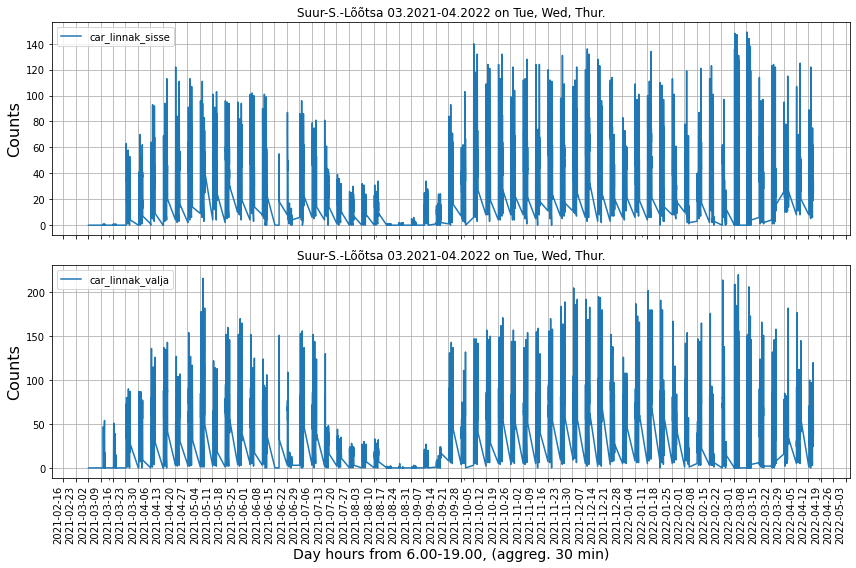

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=1,sharex=True, sharey=False)

data['car_linnak_sisse'].plot(ax=axes[0], figsize=(12, 8), 
                      title="Suur-S.-Lõõtsa 03.2021-04.2022 on Tue, Wed, Thur.")
axes[0].grid(True)
axes[0].legend()
axes[0].set_ylabel("Counts", size=16)

data['car_linnak_valja'].plot(ax=axes[1], figsize=(12, 8), 
                      title="Suur-S.-Lõõtsa 03.2021-04.2022 on Tue, Wed, Thur.")
axes[1].grid(True)
axes[1].legend()
axes[1].set_ylabel("Counts", size=16)
axes[1].xaxis.set_major_locator(mdates.WeekdayLocator())

plt.xticks(rotation='90', size = 10)
plt.xlabel("Day hours from 6.00-19.00, (aggreg. 30 min)", size=14)
fig.tight_layout()
plt.savefig("stat_car.pdf", format="pdf", bbox_inches="tight")
plt.show();

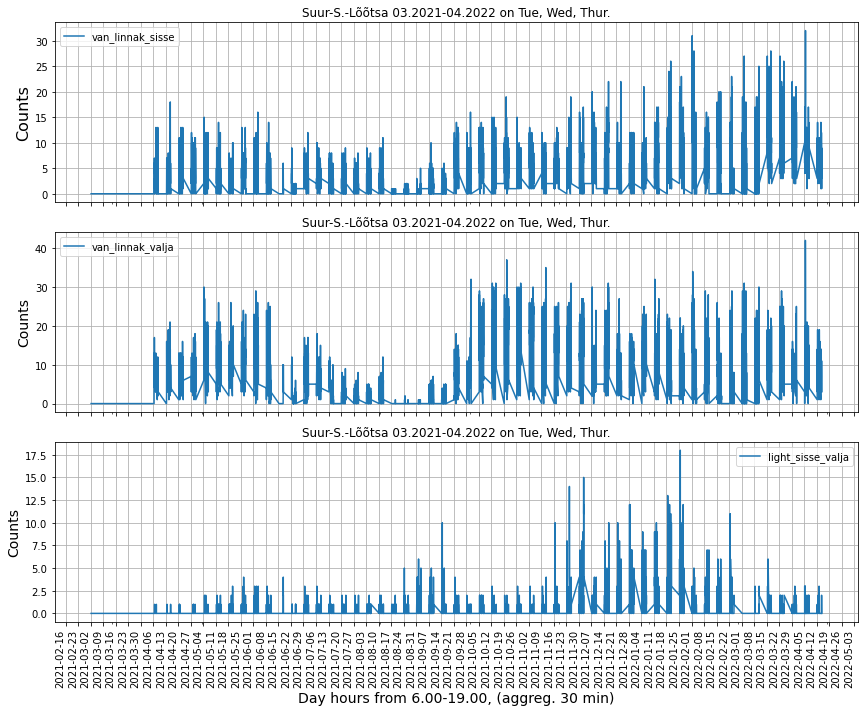

In [16]:
fig, axes = plt.subplots(nrows=3, ncols=1,sharex=True, sharey=False)

data['van_linnak_sisse'].plot(ax=axes[0], figsize=(12, 10), 
                      title="Suur-S.-Lõõtsa 03.2021-04.2022 on Tue, Wed, Thur.")
axes[0].grid(True)
axes[0].legend()
axes[0].set_ylabel("Counts", size=16)

data['van_linnak_valja'].plot(ax=axes[1], figsize=(12, 10), 
                      title="Suur-S.-Lõõtsa 03.2021-04.2022 on Tue, Wed, Thur.")
axes[1].grid(True)
axes[1].legend()
axes[1].set_ylabel("Counts", size=14)

df_light['light_sisse_valja'].plot(ax=axes[2], figsize=(12, 10), 
                                   title="Suur-S.-Lõõtsa 03.2021-04.2022 on Tue, Wed, Thur.")
axes[2].grid(True)
axes[2].legend()
axes[2].set_ylabel("Counts", size=14)
axes[2].xaxis.set_major_locator(mdates.WeekdayLocator())


plt.xticks(rotation='90',size = 10)
plt.xlabel("Day hours from 6.00-19.00, (aggreg. 30 min)", size=14)
fig.tight_layout()
plt.savefig("stat_van_light.pdf", format="pdf", bbox_inches="tight")
plt.show();

## Statistics of Heavy and Light traffic

In [17]:
labels = ['March', 'April', 'May','June', 'July', 'August', 'September', 'October', 'November',
         'December', 'January', 'February', 'March', 'April']

In [18]:
def boxplot_monthly(data, field_name, labels):
    one_year = data[field_name]
    groups = one_year.groupby(Grouper(freq='M'))
    
    #for name, group in groups:
        #print(name.month)
        #print(len(group.values))
    
    months = concat([DataFrame(x[1].values) for x in groups], axis=1)
    months = DataFrame(months)
    months.columns = range(1, months.shape[1] + 1)

    plt.rcParams["figure.figsize"] = (10,6);
    months.boxplot(showmeans=True)
    plt.xticks([i for i in range(1, months.shape[1] + 1)], labels,  rotation='vertical')
    plt.title(f"{field_name}: Counts Monthly", size=15)
    pyplot.show()
    

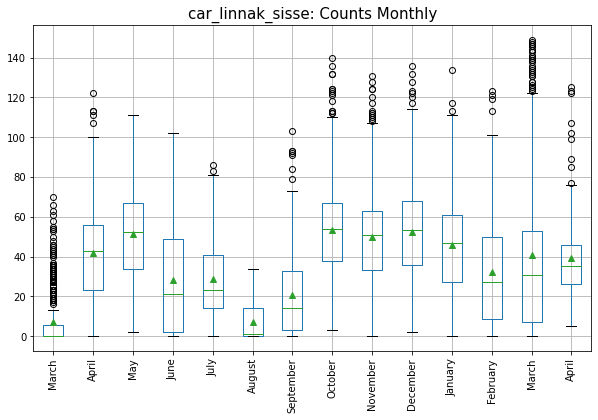

In [19]:
carssl_in_box = boxplot_monthly(data, 'car_linnak_sisse', labels)

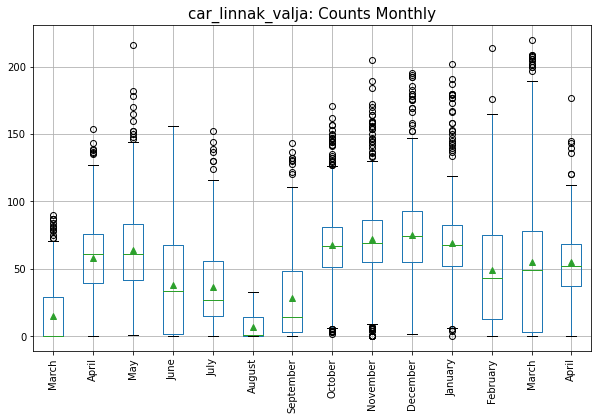

In [20]:
carssl_out_box = boxplot_monthly(data, 'car_linnak_valja', labels)

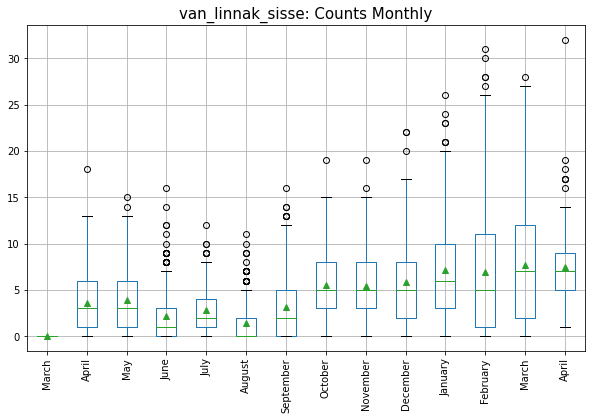

In [21]:
vanssl_in_box = boxplot_monthly(data, 'van_linnak_sisse', labels)

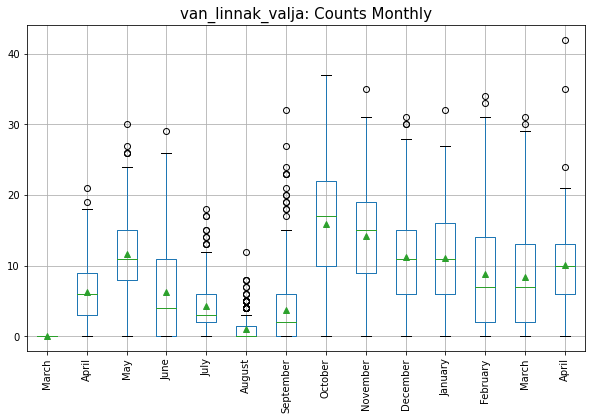

In [22]:
vanssl_out_box = boxplot_monthly(data, 'van_linnak_valja', labels)

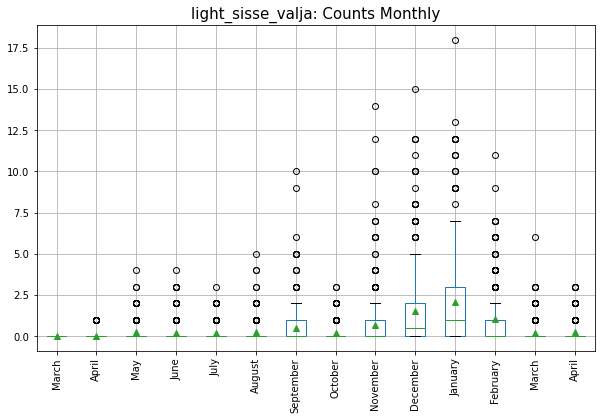

In [23]:
light_box = boxplot_monthly(df_light, 'light_sisse_valja', labels)

In [24]:
#print("These are Heavy_traffic\n", df_heavy.describe())
#print("These are Light_traffic\n", df_light.describe())

## Extracting valuable TRAFFIC data based on ML model performance

* Car_linnak_sisse, Car_linnak_valja: 06.04.2021-12.08.2021 and 07.09.2021-18.04.2022
* Van_linnak_sisse, Van_linnak_valja: 06.04.2021-12.08.2021 and 07.09.2021-18.04.2022
* Light_sisse_valja: 06.04.2021-24.02.2022 and 22.03.2022-18.04.2022


In [25]:
data.reset_index(inplace=True)

### CAR/VAN Data  with excluded time_period from 12.08.2021-07.09.2021

In [26]:
start_all = '2021-04-06 06:00:00'

mask_all= (data['timestamp'] >= start_all) 
data = data.loc[mask_all]

In [27]:
df_carvan = data.copy()
df_light_inout = data.copy()

In [28]:
start_date = '2021-08-12 19:00:00'
end_date = '2021-09-07 06:00:00'

mask1 = (df_carvan['timestamp'] <= start_date) 
mask2 = (df_carvan['timestamp'] >= end_date) 

before_Aug = df_carvan.loc[mask1]
after_Sept = df_carvan.loc[mask2]

df_carvan = pd.concat([before_Aug, after_Sept], axis=0)

In [29]:
start_light = '2022-02-24 19:00:00'
end_light = '2022-03-22 06:00:00'

mask3 = (df_light_inout['timestamp'] <= start_light) 
mask4 = (df_light_inout['timestamp'] >= end_light) 

before_Feb = df_light_inout.loc[mask3]
after_March = df_light_inout.loc[mask4]

df_light_inout = pd.concat([before_Feb, after_March], axis=0)

In [30]:
#for i in df_light_inout['timestamp']:
    #print(i)

In [31]:
df_carvan.set_index('timestamp', inplace=True)
df_light_inout.set_index('timestamp', inplace=True)

In [32]:
df_carvan_in = df_carvan.copy()
df_carvan_out = df_carvan.copy()
df_light = df_light_inout.copy()

In [33]:
df_carvan_in = df_carvan_in[['car_linnak_sisse', 'van_linnak_sisse']]

df_carvan_out = df_carvan_out[['car_linnak_valja' ,'van_linnak_valja']]

df_light = df_light[['bicycle_linnak_sisse', 'bicycle_linnak_valja', 'escooter_linnak_valja', 
                     'motorbike_linnak_sisse', 'motorbike_linnak_valja']]

In [34]:
incom_outgo = ['bicycle_linnak_sisse', 'bicycle_linnak_valja', 'escooter_linnak_valja', 
                     'motorbike_linnak_sisse', 'motorbike_linnak_valja']
df_light['light_sisse_valja'] = df_light[incom_outgo].sum(axis=1).astype('int64')

In [35]:
print(df_carvan_in.shape)
print(df_carvan_out.shape)
print(df_light.shape)

(4131, 2)
(4131, 2)
(4131, 6)


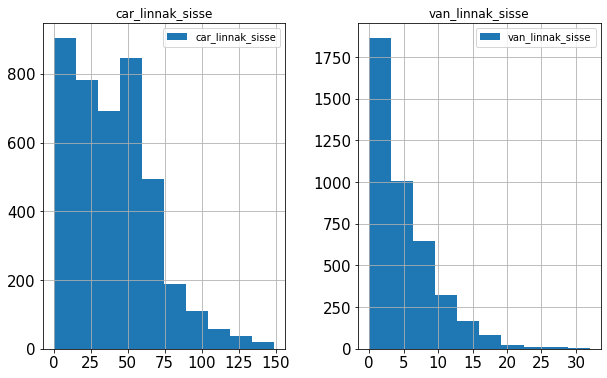

In [132]:
plt.rcParams["figure.figsize"] = (10,6);
df_carvan_in.hist(xlabelsize=15, ylabelsize=15, sharex=False, sharey=False, legend=True)
plt.savefig("hist_carvansisse.pdf", format="pdf", bbox_inches="tight")
pyplot.show()

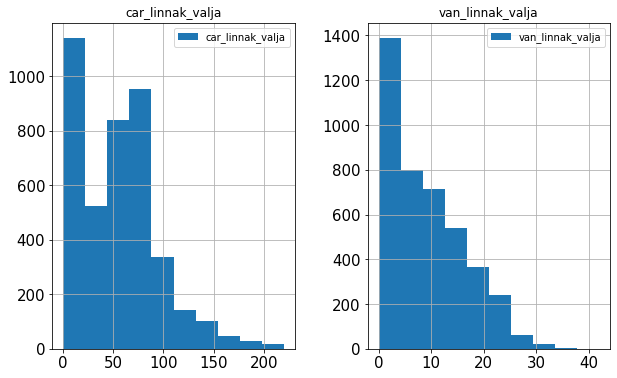

In [133]:
plt.rcParams["figure.figsize"] = (10,6);
df_carvan_out.hist(xlabelsize=15, ylabelsize=15, sharex=False, sharey=False, legend=True)
plt.savefig("hist_carvanvalja.pdf", format="pdf", bbox_inches="tight")
pyplot.show()

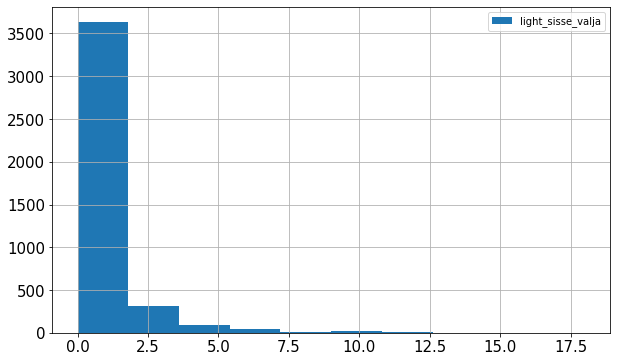

In [135]:
plt.rcParams["figure.figsize"] = (10,6);
df_light['light_sisse_valja'].hist(xlabelsize=15, ylabelsize=15, legend=True)
#plt.xlim([0, max(df_light['light_sisse_valja'])])
plt.savefig("hist_light.pdf", format="pdf", bbox_inches="tight")
pyplot.show();

The histogram plots of the traffic data demonstrate right-skewness (right-tail, positive skewness). Typical transformations could be, such as:

* power: square, cube root;
* log;
* moving window, i.e. rolling mean over a selected period;
* moving window on power transformed data;
* linear regression

# Loading EMHI data;
# Extracting time_periods corrsponding to valuable Traffic data

    * Car_linnak_sisse, Car_linnak_valja: 06.04.2021-12.08.2021 and 07.09.2021-18.04.2022
    * Van_linnak_sisse, Van_linnak_valja: 06.04.2021-12.08.2021 and 07.09.2021-18.04.2022
    * Light_sisse_valja: 06.04.2021-24.02.2022 and 22.03.2022-18.04.2022


In [39]:
path = "/home/meik/Mainor_ylemiste/data_emhi/Ilmaandmed 01.03-31.12.2021a/data_TKN/from04.2021/"

os.chdir(path)
path

'/home/meik/Mainor_ylemiste/data_emhi/Ilmaandmed 01.03-31.12.2021a/data_TKN/from04.2021/'

In [40]:
data_emhi = []
for file in os.listdir():
    if file.endswith(".csv"):
        file_path = f"{path}{file}"
        dd = pdread_csv(file_path)   
        data_emhi.append(dd)
        
data_emhi = (pd.concat(data_emhi, ignore_index=True, sort=False)).fillna(0)
print(data_emhi.shape)

(4401, 10)


In [41]:
data_emhi = data_emhi.sort_values(by='kuupaev')
data_emhi.reset_index(inplace=True)
data_emhi.head(5)
del data_emhi['index']

In [42]:
# convert column "timestamp" into Datetime objects, add into original column "timestamp"
convertToDate = lambda row: datetime.strptime(row['kuupaev'], "%Y-%m-%d %H:%M:%S")
data_emhi['kuupaev'] = data_emhi.apply(convertToDate, axis=1)
#data

### Extracting EMHI data corresponding to valuable Traffic data

In [43]:
start_all = '2021-04-06 05:50:00'

start_date = '2021-08-12 18:50:00'
end_date = '2021-09-07 05:50:00'

start_light = '2022-02-24 18:50:00'
end_light = '2022-03-22 05:50:00'

In [44]:
mask_all_emhi= (data_emhi['kuupaev'] >= start_all) 
data_emhi = data_emhi.loc[mask_all_emhi]

In [45]:
data_emhi_light = data_emhi.copy()

### DATA_EMHI FOR CAR and VAN

In [46]:
mask1_emhi = (data_emhi['kuupaev'] <= start_date) 
mask2_emhi = (data_emhi['kuupaev'] >= end_date) 
before_Aug_emhi = data_emhi.loc[mask1_emhi]
after_Sept_emhi = data_emhi.loc[mask2_emhi]

data_emhi = pd.concat([before_Aug_emhi, after_Sept_emhi], axis=0)

In [47]:
data_emhi.set_index('kuupaev', inplace=True)

### Classification of "weather_phenomena (ilmastiku nähtus)".

Weather phenomena is distinguished between **4 main classes**, which are related to weather phenomena abbreviations. 

In [48]:
weather_phCAT = []

for i in data_emhi['ilmast_nahtused']:
    if i == 0:
        weather_phCAT.append("NA")
    elif i == "SN" or i=='SHGS*' or i=='SHSN** SHGS'  or i=='SHSN**' or i == "SN " or i == "SN*" or i == "SN* " or i == "SN*  " or i == "SN**" or i == "SN** " or i == "SHSN" or i == "SHSN " or i == "SHSN*" or i == "SHSN* ":
        weather_phCAT.append("SN")
    elif i == 'SHRA* SHSN*' or i == "SN*RA*" or i=='SHSN SHRA' or i=='SHRA  VCTS' or i=='FZDZ* SN*' or i=='SHSN SHRA' or i=='RA SN*' or i == "SN* RA* " or i == "RA*SN*" or i == "RA* SN*" or i == 'SHRA SHSN' or i=='SN RA*' or i=='SN* RA*' or i=='SN RA' or i=='FZRA* SN* ' or i == "RA" or i == "RA " or i=='VCTS' or i == "RA*" or i == "RA* " or i == "SHRA" or i == "SHRA " or i == "SHRA* VCTS" or i == "SHRA*VCTS" or i=='TSRA**' or i =='TSRA' or i=='SHRA*' or i=='SHRA**':
        weather_phCAT.append("RA")
    elif i == "DZ" or i == "DZ " or i == "DZ*" or i == "DZ* " or i == "FZDZ*" or i == "FZDZ* " or i == 'RA* DZ* ' or i == 'RA DZ* ' or i == 'DZ* RA* ' or i == 'DZ  RA* ' or i == 'RA DZ*' or i == 'DZRA*' or i == 'RA DZ' or i == 'DZ*RA* ' or i == "DZ*RA*" or i == "DZ* RA*" or i == "RA* DZ*" or i == "RA*DZ*" or i == "RA*DZ* " or i == "DZ RA*" or i == "DZ RA* " or i=='DZ RA' or i=='DZ RA':
        weather_phCAT.append("DZ")                
    #elif i == 'SHRA* SHSN*' or i == "SN*RA*" or i=='SHSN SHRA' or i=='SHRA  VCTS' or i=='FZDZ* SN*' or i=='SHSN SHRA' or i=='RA SN*' or i == "SN* RA* " or i == "RA*SN*" or i == "RA* SN*" or i == 'SHRA SHSN' or i=='SN RA*' or i=='SN* RA*' or i=='SN RA' or i=='FZRA* SN* ':
        #weather_phCAT.append("RASN")
    #elif i == 'RA* DZ* ' or i == 'RA DZ* ' or i == 'DZ* RA* ' or i == 'DZ  RA* ' or i == 'RA DZ*' or i == 'DZRA*' or i == 'RA DZ' or i == 'DZ*RA* ' or i == "DZ*RA*" or i == "DZ* RA*" or i == "RA* DZ*" or i == "RA*DZ*" or i == "RA*DZ* " or i == "DZ RA*" or i == "DZ RA* " or i=='DZ RA' or i=='DZ RA':
        #weather_phCAT.append("RADZ")
    else:
        weather_phCAT.append(i)

In [49]:
weather_phNUM = []

for i in data_emhi['ilmast_nahtused']:
    if i == 0:
        weather_phNUM.append(1)
    elif i == "SN" or i=='SHGS*' or i=='SHSN** SHGS'  or i=='SHSN**' or i == "SN " or i == "SN*" or i == "SN* " or i == "SN*  " or i == "SN**" or i == "SN** " or i == "SHSN" or i == "SHSN " or i == "SHSN*" or i == "SHSN* ":
        weather_phNUM.append(2)
    elif i == 'SHRA* SHSN*' or i == "SN*RA*" or i=='SHSN SHRA' or i=='SHRA  VCTS' or i=='FZDZ* SN*' or i=='SHSN SHRA' or i=='RA SN*' or i == "SN* RA* " or i == "RA*SN*" or i == "RA* SN*" or i == 'SHRA SHSN' or i=='SN RA*' or i=='SN* RA*' or i=='SN RA' or i=='FZRA* SN* ' or i == "RA" or i == "RA " or i=='VCTS' or i == "RA*" or i == "RA* " or i == "SHRA" or i == "SHRA " or i == "SHRA* VCTS" or i == "SHRA*VCTS" or i=='TSRA**' or i =='TSRA' or i=='SHRA*' or i=='SHRA**':
        weather_phNUM.append(3)
    elif i == "DZ" or i == "DZ " or i == "DZ*" or i == "DZ* " or i == "FZDZ*" or i == "FZDZ* " or i == 'RA* DZ* ' or i == 'RA DZ* ' or i == 'DZ* RA* ' or i == 'DZ  RA* ' or i == 'RA DZ*' or i == 'DZRA*' or i == 'RA DZ' or i == 'DZ*RA* ' or i == "DZ*RA*" or i == "DZ* RA*" or i == "RA* DZ*" or i == "RA*DZ*" or i == "RA*DZ* " or i == "DZ RA*" or i == "DZ RA* " or i=='DZ RA' or i=='DZ RA':
        weather_phNUM.append(4)                
    #elif i == 'SHRA* SHSN*' or i == "SN*RA*" or i=='SHSN SHRA' or i=='SHRA  VCTS' or i=='FZDZ* SN*' or i=='SHSN SHRA' or i=='RA SN*' or i == "SN* RA* " or i == "RA*SN*" or i == "RA* SN*" or i == 'SHRA SHSN' or i=='SN RA*' or i=='SN* RA*' or i=='SN RA' or i=='FZRA* SN* ':
        #weather_phCAT.append("RASN")
    #elif i == 'RA* DZ* ' or i == 'RA DZ* ' or i == 'DZ* RA* ' or i == 'DZ  RA* ' or i == 'RA DZ*' or i == 'DZRA*' or i == 'RA DZ' or i == 'DZ*RA* ' or i == "DZ*RA*" or i == "DZ* RA*" or i == "RA* DZ*" or i == "RA*DZ*" or i == "RA*DZ* " or i == "DZ RA*" or i == "DZ RA* " or i=='DZ RA' or i=='DZ RA':
        #weather_phCAT.append("RADZ")
    else:
        weather_phNUM.append(i)

In [50]:
print(len(weather_phCAT))
combin_counts = Counter(weather_phCAT)
print(len(combin_counts.keys()))
print(combin_counts.keys())
print(combin_counts.values())

4131
4
dict_keys(['NA', 'SN', 'RA', 'DZ'])
dict_values([3318, 347, 286, 180])


In [51]:
data_emhi.insert(loc=5, column='weather_phenCAT', value=weather_phCAT)

In [52]:
data_emhi.insert(loc=6, column='weather_phenLAB', value=weather_phNUM)

In [53]:
visibility0 = []
for i in data_emhi['nahtavus']:
    if i == 10 or i == "10":
        visibility0.append(int(i)*1000)
    else:
        visibility0.append(i)     

In [54]:
visibility = []
for i in visibility0:     
    if type(i) == str and (len(i) == 4 or len(i) == 3):
        visibility.append(int(i))
    elif type(i) == str and len(i) > 5:
        ch = '/'
        visibility.append(int(i.split(ch, 1)[0]))
    else:
        visibility.append(i)    

In [55]:
data_emhi.insert(loc=4, column='visibility_m', value=visibility)

In [56]:
#data_emhi.head(2)

In [57]:
path = "/home/meik/Mainor_ylemiste/report/figures/pdf_figures/"

os.chdir(path)
path

'/home/meik/Mainor_ylemiste/report/figures/pdf_figures/'

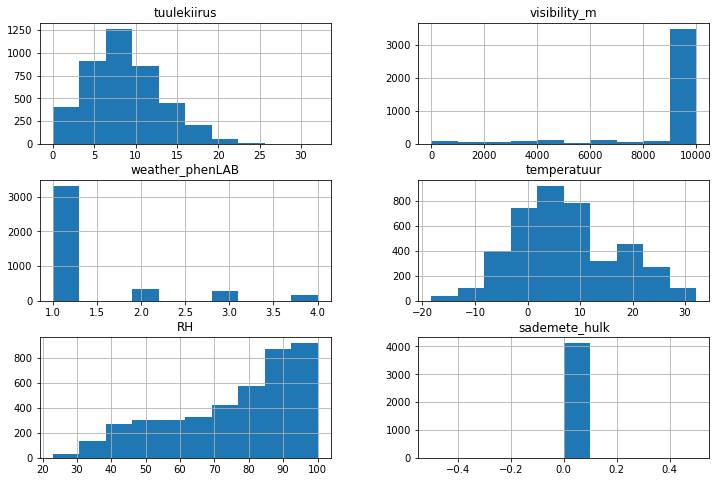

In [58]:
plt.rcParams["figure.figsize"] = (12,8);
data_emhi.hist()
plt.savefig("weather_stat.pdf", format="pdf", bbox_inches="tight")

## Encoding the weather data using Binary encoding

In [59]:
encoderBi = ce.BinaryEncoder(cols =['weather_phenCAT'])
newdataBi = encoderBi.fit_transform(data_emhi['weather_phenCAT'])

data_emhi = pd.concat([data_emhi, newdataBi], axis = 1)
#data_emhi = data_emhi.drop(['weather_phenCAT'], axis = 1)

In [60]:
data_emhi[635:638]

,kellaaeg_utc,tuulesuund,tuulekiirus,nahtavus,visibility_m,ilmast_nahtused,weather_phenCAT,weather_phenLAB,pilvede_alapiir,temperatuur,RH,sademete_hulk,weather_phenCAT_0,weather_phenCAT_1,weather_phenCAT_2
kuupaev,,,,,,,,,,,,,,,
2021-05-27 12:50:00,09:50:00,170,8,10,10000,0,NA,1,4100,12.0,77,0.0,0,0,1
2021-05-27 13:20:00,10:20:00,190,6,10,10000,0,NA,1,4400,11.9,79,0.0,0,0,1
2021-05-27 13:50:00,10:50:00,180,6,10,10000,SHRA*,RA,3,3900,12.1,82,0.0,0,1,1


In [61]:
# Dummy encoding of weather phenomena
#data_emhi = pd.get_dummies(data_emhi, prefix=['weather_ph'], columns=['weather_phenCAT'])

### DATA_EMHI FOR LIGHT_SISSE/VÄLJA

In [62]:
mask3_emhi = (data_emhi_light['kuupaev'] <= start_light) 
mask4_emhi = (data_emhi_light['kuupaev'] >= end_light) 
before_Feb_emhi = data_emhi_light.loc[mask3_emhi]
after_Mar_emhi = data_emhi_light.loc[mask4_emhi]

data_emhi_light = pd.concat([before_Feb_emhi, after_Mar_emhi], axis=0)

In [63]:
data_emhi_light.set_index('kuupaev', inplace=True)

### Classification of "weather_phenomena (ilmastiku nähtus)".

Weather phenomena is distinguished between **4 main classes**, which are related to weather phenomena abbreviations. 

In [64]:
weather_phCAT = []

for i in data_emhi_light['ilmast_nahtused']:
    if i == 0:
        weather_phCAT.append("NA")
    elif i == "SN" or i=='SHGS*' or i=='SHSN** SHGS'  or i=='SHSN**' or i == "SN " or i == "SN*" or i == "SN* " or i == "SN*  " or i == "SN**" or i == "SN** " or i == "SHSN" or i == "SHSN " or i == "SHSN*" or i == "SHSN* ":
        weather_phCAT.append("SN")
    elif i == 'SHRA* SHSN*' or i == "SN*RA*" or i=='SHSN SHRA' or i=='SHRA  VCTS' or i=='FZDZ* SN*' or i=='SHSN SHRA' or i=='RA SN*' or i == "SN* RA* " or i == "RA*SN*" or i == "RA* SN*" or i == 'SHRA SHSN' or i=='SN RA*' or i=='SN* RA*' or i=='SN RA' or i=='FZRA* SN* ' or i == "RA" or i == "RA " or i=='VCTS' or i == "RA*" or i == "RA* " or i == "SHRA" or i == "SHRA " or i == "SHRA* VCTS" or i == "SHRA*VCTS" or i=='TSRA**' or i =='TSRA' or i=='SHRA*' or i=='SHRA**':
        weather_phCAT.append("RA")
    elif i == "DZ" or i == "DZ " or i == "DZ*" or i == "DZ* " or i == "FZDZ*" or i == "FZDZ* " or i == 'RA* DZ* ' or i == 'RA DZ* ' or i == 'DZ* RA* ' or i == 'DZ  RA* ' or i == 'RA DZ*' or i == 'DZRA*' or i == 'RA DZ' or i == 'DZ*RA* ' or i == "DZ*RA*" or i == "DZ* RA*" or i == "RA* DZ*" or i == "RA*DZ*" or i == "RA*DZ* " or i == "DZ RA*" or i == "DZ RA* " or i=='DZ RA' or i=='DZ RA':
        weather_phCAT.append("DZ")                
    #elif i == 'SHRA* SHSN*' or i == "SN*RA*" or i=='SHSN SHRA' or i=='SHRA  VCTS' or i=='FZDZ* SN*' or i=='SHSN SHRA' or i=='RA SN*' or i == "SN* RA* " or i == "RA*SN*" or i == "RA* SN*" or i == 'SHRA SHSN' or i=='SN RA*' or i=='SN* RA*' or i=='SN RA' or i=='FZRA* SN* ':
        #weather_phCAT.append("RASN")
    #elif i == 'RA* DZ* ' or i == 'RA DZ* ' or i == 'DZ* RA* ' or i == 'DZ  RA* ' or i == 'RA DZ*' or i == 'DZRA*' or i == 'RA DZ' or i == 'DZ*RA* ' or i == "DZ*RA*" or i == "DZ* RA*" or i == "RA* DZ*" or i == "RA*DZ*" or i == "RA*DZ* " or i == "DZ RA*" or i == "DZ RA* " or i=='DZ RA' or i=='DZ RA':
        #weather_phCAT.append("RADZ")
    else:
        weather_phCAT.append(i)

In [65]:
weather_phNUM = []

for i in data_emhi_light['ilmast_nahtused']:
    if i == 0:
        weather_phNUM.append(1)
    elif i == "SN" or i=='SHGS*' or i=='SHSN** SHGS'  or i=='SHSN**' or i == "SN " or i == "SN*" or i == "SN* " or i == "SN*  " or i == "SN**" or i == "SN** " or i == "SHSN" or i == "SHSN " or i == "SHSN*" or i == "SHSN* ":
        weather_phNUM.append(2)
    elif i == 'SHRA* SHSN*' or i == "SN*RA*" or i=='SHSN SHRA' or i=='SHRA  VCTS' or i=='FZDZ* SN*' or i=='SHSN SHRA' or i=='RA SN*' or i == "SN* RA* " or i == "RA*SN*" or i == "RA* SN*" or i == 'SHRA SHSN' or i=='SN RA*' or i=='SN* RA*' or i=='SN RA' or i=='FZRA* SN* ' or i == "RA" or i == "RA " or i=='VCTS' or i == "RA*" or i == "RA* " or i == "SHRA" or i == "SHRA " or i == "SHRA* VCTS" or i == "SHRA*VCTS" or i=='TSRA**' or i =='TSRA' or i=='SHRA*' or i=='SHRA**':
        weather_phNUM.append(3)
    elif i == "DZ" or i == "DZ " or i == "DZ*" or i == "DZ* " or i == "FZDZ*" or i == "FZDZ* " or i == 'RA* DZ* ' or i == 'RA DZ* ' or i == 'DZ* RA* ' or i == 'DZ  RA* ' or i == 'RA DZ*' or i == 'DZRA*' or i == 'RA DZ' or i == 'DZ*RA* ' or i == "DZ*RA*" or i == "DZ* RA*" or i == "RA* DZ*" or i == "RA*DZ*" or i == "RA*DZ* " or i == "DZ RA*" or i == "DZ RA* " or i=='DZ RA' or i=='DZ RA':
        weather_phNUM.append(4)                
    #elif i == 'SHRA* SHSN*' or i == "SN*RA*" or i=='SHSN SHRA' or i=='SHRA  VCTS' or i=='FZDZ* SN*' or i=='SHSN SHRA' or i=='RA SN*' or i == "SN* RA* " or i == "RA*SN*" or i == "RA* SN*" or i == 'SHRA SHSN' or i=='SN RA*' or i=='SN* RA*' or i=='SN RA' or i=='FZRA* SN* ':
        #weather_phCAT.append("RASN")
    #elif i == 'RA* DZ* ' or i == 'RA DZ* ' or i == 'DZ* RA* ' or i == 'DZ  RA* ' or i == 'RA DZ*' or i == 'DZRA*' or i == 'RA DZ' or i == 'DZ*RA* ' or i == "DZ*RA*" or i == "DZ* RA*" or i == "RA* DZ*" or i == "RA*DZ*" or i == "RA*DZ* " or i == "DZ RA*" or i == "DZ RA* " or i=='DZ RA' or i=='DZ RA':
        #weather_phCAT.append("RADZ")
    else:
        weather_phNUM.append(i)

In [66]:
print(len(weather_phCAT))
combin_counts = Counter(weather_phCAT)
print(len(combin_counts.keys()))
print(combin_counts.keys())
print(combin_counts.values())

4131
4
dict_keys(['NA', 'SN', 'RA', 'DZ'])
dict_values([3279, 325, 348, 179])


In [67]:
data_emhi_light.insert(loc=5, column='weather_phenCAT', value=weather_phCAT)

In [68]:
data_emhi_light.insert(loc=6, column='weather_phenLAB', value=weather_phNUM)

In [69]:
visibility0 = []
for i in data_emhi_light['nahtavus']:
    if i == 10 or i == "10":
        visibility0.append(int(i)*1000)
    else:
        visibility0.append(i) 

In [70]:
visibility = []
for i in visibility0:     
    if type(i) == str and (len(i) == 4 or len(i) == 3):
        visibility.append(int(i))
    elif type(i) == str and len(i) > 5:
        ch = '/'
        visibility.append(int(i.split(ch, 1)[0]))
    else:
        visibility.append(i)

In [71]:
data_emhi_light.insert(loc=4, column='visibility_m', value=visibility)

In [72]:
data_emhi_light.head(2)

,kellaaeg_utc,tuulesuund,tuulekiirus,nahtavus,visibility_m,ilmast_nahtused,weather_phenCAT,weather_phenLAB,pilvede_alapiir,temperatuur,RH,sademete_hulk
kuupaev,,,,,,,,,,,,
2021-04-06 05:50:00,02:50:00,190,11,10,10000,0,NA,1,1./1400,-1.8,88,0.0
2021-04-06 06:20:00,03:20:00,190,12,10,10000,0,NA,1,2./1300,-1.5,87,0.0


array([[<AxesSubplot:title={'center':'tuulekiirus'}>,
        <AxesSubplot:title={'center':'visibility_m'}>],
       [<AxesSubplot:title={'center':'weather_phenLAB'}>,
        <AxesSubplot:title={'center':'temperatuur'}>],
       [<AxesSubplot:title={'center':'RH'}>,
        <AxesSubplot:title={'center':'sademete_hulk'}>]], dtype=object)

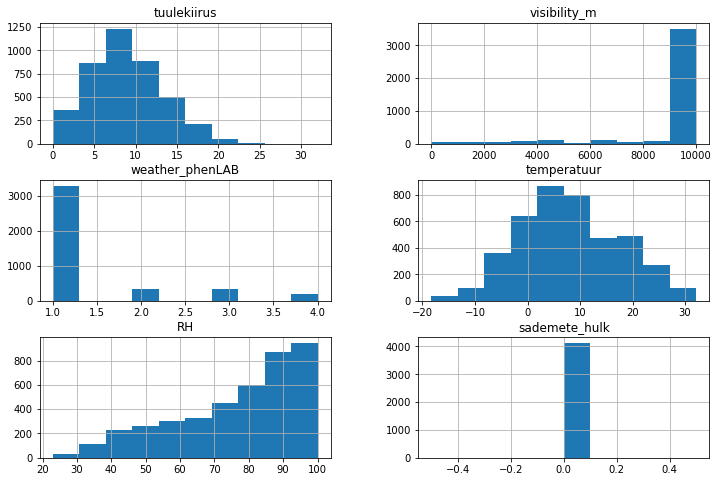

In [73]:
plt.rcParams["figure.figsize"] = (12,8);
data_emhi_light.hist()

## Encoding the weather data_light using Binary encoding

In [74]:
encoderBi_l = ce.BinaryEncoder(cols =['weather_phenCAT'])
newdataBi_l = encoderBi_l.fit_transform(data_emhi_light['weather_phenCAT'])

data_emhi_light = pd.concat([data_emhi_light, newdataBi_l], axis = 1)

In [75]:
data_emhi_light.head(3)

,kellaaeg_utc,tuulesuund,tuulekiirus,nahtavus,visibility_m,ilmast_nahtused,weather_phenCAT,weather_phenLAB,pilvede_alapiir,temperatuur,RH,sademete_hulk,weather_phenCAT_0,weather_phenCAT_1,weather_phenCAT_2
kuupaev,,,,,,,,,,,,,,,
2021-04-06 05:50:00,02:50:00,190,11,10,10000,0,NA,1,1./1400,-1.8,88,0.0,0,0,1
2021-04-06 06:20:00,03:20:00,190,12,10,10000,0,NA,1,2./1300,-1.5,87,0.0,0,0,1
2021-04-06 06:50:00,03:50:00,190,13,10,10000,0,NA,1,7200,-1.1,86,0.0,0,0,1


# Lagged TRAFFIC data (previous observation (lag))

There are lags as follows:

* Lag = 27 (one day lag);
* Lag = 54 (two days lag);
* Lag = 81 (one week lag).

In [76]:
car_sslin_lag27 = df_carvan_in['car_linnak_sisse'].shift(-27)
car_sslin_lag54 = df_carvan_in['car_linnak_sisse'].shift(-54)
car_sslin_lag81 = df_carvan_in['car_linnak_sisse'].shift(-81)

In [77]:
car_sslout_lag27 = df_carvan_out['car_linnak_valja'].shift(-27)
car_sslout_lag54 = df_carvan_out['car_linnak_valja'].shift(-54)
car_sslout_lag81 = df_carvan_out['car_linnak_valja'].shift(-81)

In [78]:
van_sslin_lag27 = df_carvan_in['van_linnak_sisse'].shift(-27)
van_sslin_lag54 = df_carvan_in['van_linnak_sisse'].shift(-54)
van_sslin_lag81 = df_carvan_in['van_linnak_sisse'].shift(-81)

In [79]:
van_sslout_lag27 = df_carvan_out['van_linnak_valja'].shift(-27)
van_sslout_lag54 = df_carvan_out['van_linnak_valja'].shift(-54)
van_sslout_lag81 = df_carvan_out['van_linnak_valja'].shift(-81)

In [80]:
light_ssl_lag27 = df_light['light_sisse_valja'].shift(-27)
light_ssl_lag54 = df_light['light_sisse_valja'].shift(-54)
light_ssl_lag81 = df_light['light_sisse_valja'].shift(-81)

# Lag plots of TRAFFIC data

Relationship between an observation and the previous observation (lag)

In [81]:
def lagplot(data, field_name, lag1=1, lag2=1):
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    lag_plot(data[field_name],lag=lag1, ax= ax1)
    lag_plot(data[field_name],lag=lag2, ax =ax2)
    plt.title(f"{field_name}. Correlation between an observation and previous observation: Lag of {lag1} and {lag2}.", size=15)
    
    #plt.rcParams["figure.figsize"] = (10,6)
    #plt.xlabel("Observation y(t)", size=15)
    #plt.ylabel(f"Observation y(t + {lag})", size=15)
    #plt.title(f"{field_name}. Correlation between an observation and previous observation--lag of {lag}.", size=15)
    #pyplot.show();

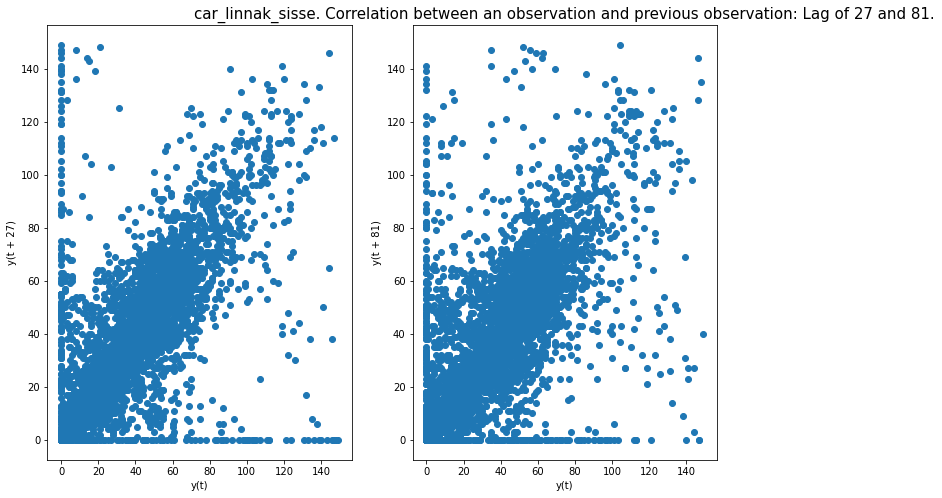

In [82]:
carSSL_lag_in = lagplot(df_carvan_in, 'car_linnak_sisse', lag1=27, lag2=81)

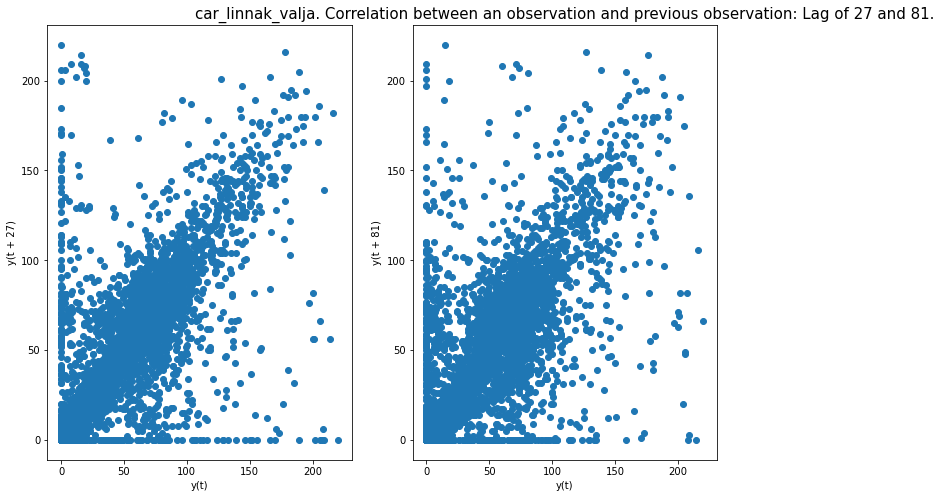

In [83]:
carSSL_lag_out = lagplot(df_carvan_out, 'car_linnak_valja', lag1=27, lag2=81)

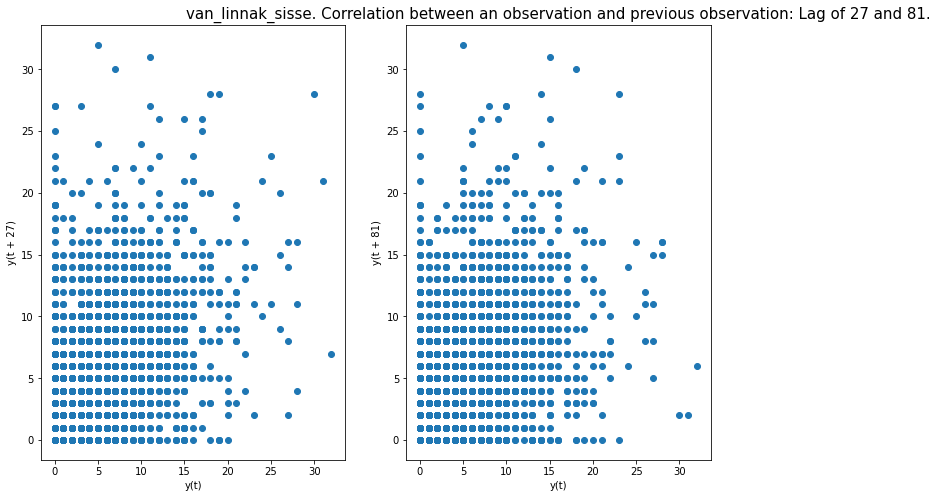

In [84]:
vanSSL_lag_in = lagplot(df_carvan_in, 'van_linnak_sisse', lag1=27, lag2=81)

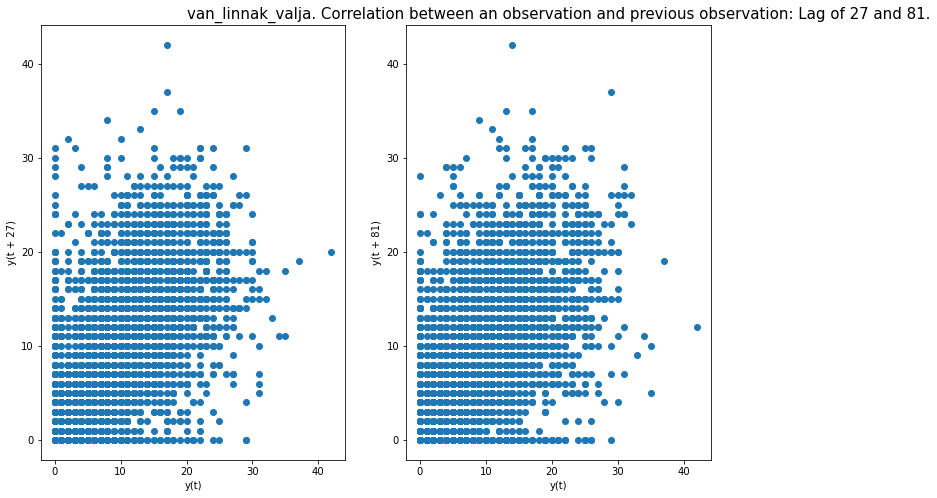

In [85]:
vanSSL_lag_out = lagplot(df_carvan_out, 'van_linnak_valja', lag1=27, lag2=81)

## AUTOCORRELATION OF TRAFFIC DATA

To quantify the strength and type of correlation between observations and their Lags.
When calculated against Lag values in time series, it is called autocorrelation (self-correlation).

It helps better understand how self-correlation changes over the Lag.

In [86]:
def acor(data, field_name, lag1=None, lag2=None):
    
    #lags=np.arange(len(corr)) # this value is set by default
    plt.rcParams["figure.figsize"] = (16,7)
    fig, (ax1, ax2) = plt.subplots(1, 2)  
    
    plot_acf(data[[field_name]], lags=lag1, title=f"{field_name}. Autocorrelation with {lag1} Lags. \n Colored area: confidence interval\n ", ax=ax1);
    ax1.grid(True)
    ax1.set_xticks(np.arange(0, int(lag1) + 2, 5.0)) 
    ax1.tick_params(axis="x", labelsize=13) 
    ax1.tick_params(axis="y", labelsize=13) 
    
    plot_acf(data[[field_name]], lags=lag2, title=f"{field_name}. Autocorrelation with {lag2} Lags. \n Colored area: confidence interval\n ", ax=ax2);
    ax2.grid(True)
    ax2.set_xticks(np.arange(0, int(lag2) + 2, 10.0))
    ax2.tick_params(axis="x", labelsize=13)
    ax2.tick_params(axis="y", labelsize=13)
    
    plt.savefig(f"ACF{field_name}.pdf", format="pdf", bbox_inches="tight")

    #plt.xlabel(f"Lags", size=15)
    #pyplot.show()
    #"points lie beyond conf.int strong Stat. sign"
    

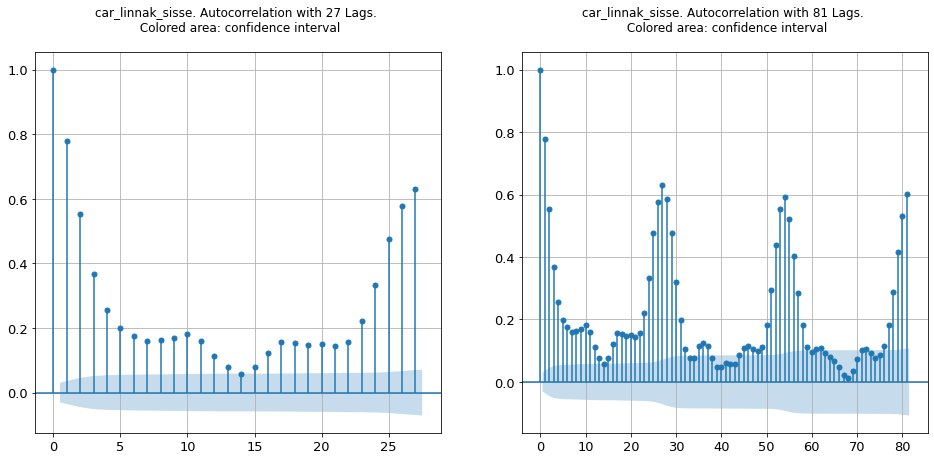

In [87]:
ac_carssl_in= acor(df_carvan_in, 'car_linnak_sisse', lag1=27, lag2=81)

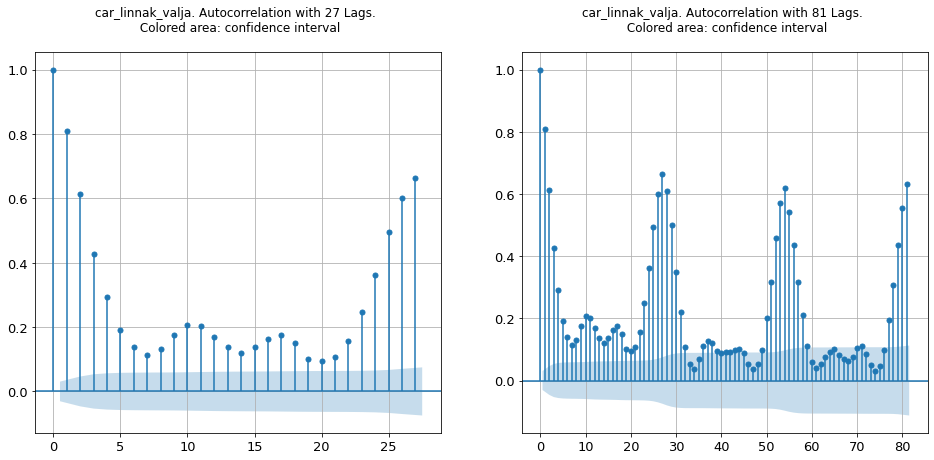

In [88]:
ac_carssl_out= acor(df_carvan_out, 'car_linnak_valja', lag1=27, lag2=81)

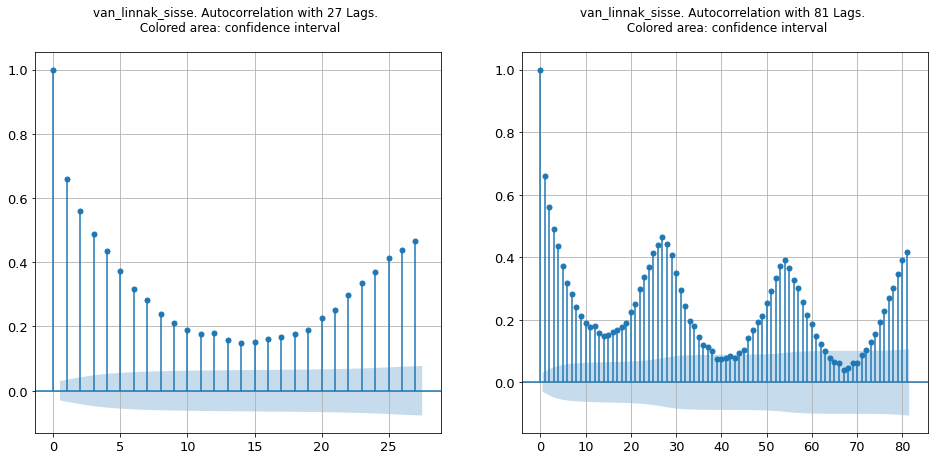

In [89]:
ac_vanssl_in= acor(df_carvan_in, 'van_linnak_sisse', lag1=27, lag2=81)

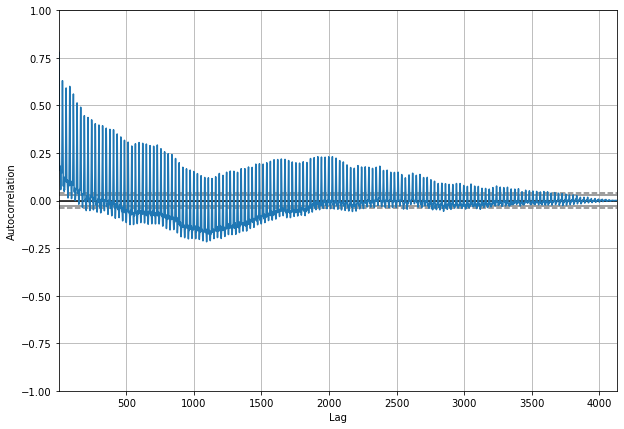

In [90]:
plt.rcParams["figure.figsize"] = (10,7)
autocorrelation_plot(df_carvan_in['car_linnak_sisse'])
pyplot.show()

# DATA TRANSFORMATION METHODS

### * Logged Transformation: take a log of each individual value of time-series data

 Reduces the variance of time-series data.
 
 ### NB! Log transform produces infinity !

In [91]:
def log_transform(data, field_name):
    
    data_log = data[field_name].apply(lambda x : np.log(x))
    
    return data_log

## * Power Transformations

Reduces the variance of time-series data.

In [92]:
def power_transform(data, field_name):
    
    data_powsq = data[field_name].apply(lambda x : x ** 0.5)
    data_powcu = data[field_name].apply(lambda x : x ** 0.3333333333333333)

    return data_powsq, data_powcu

## * Moving Window Functions

Calculate rolling mean over a selected period and subtract it from original time-series to get de-trended time-series.

In [93]:
def rolling_mean(data, field_name, window=1):
    rolling_mean = data[field_name].rolling(window = window).mean()
    data_detrended = data[field_name] - rolling_mean
    
    return data_detrended

## * Moving Window Function on Power Transformed (log) Time-Series

It is possible to apply more than one transformation.
* First apply power transformation to time-series
* Then take a rolling mean over a selected period
* Then subtract rolled time-series from power-transformed time-series to get final time-series.

In [94]:
def power_rolmean(data, field_name, window=1):
    
    power = pd.DataFrame(data[field_name].apply(lambda x : np.log(x)))
    rol_mean = power.rolling(window = window).mean()
    final = power - rol_mean

    return final

## * Linear Regression to Remove Trend

Linear regression model can be applied to remove the trend. 

* Fit a linear regression model to time-series data
* Use a fit model to predict time-series values from beginning to end
* Subtract predicted values from original time-series to remove the trend.

In [95]:
def linr_detrend(data, field_name):
       
    least_squares = OLS(data[field_name].values, list(range(data.shape[0])))
    result = least_squares.fit()

    fit = pd.Series(result.predict(list(range(data.shape[0]))), index = data.index)
    data_ols_detrended = data[field_name] - fit
    
    return data_ols_detrended

# Removing Seasonality
Remove seasonality by differencing technique: use differencing over various de-trended time-series calculated above.

## * Differencing Over Power Transformed (square root) Time-Series

Differencing is applied to power transformed time-series by shifting its value by 1 period and subtracting it from original power transformed time-series.

It is common to try shifting time-series by different time-periods to remove seasonality and get stationary time-series.

In [96]:
def power_transform_shift(data, field_name, periods=1):
    
    data_pow = data[field_name].apply(lambda x : x ** 0.5)
    data_pow_shift = data_pow - data_pow.shift(periods=periods)
    return data_pow_shift

In [98]:
#avgpowrm_car= round(carSSaasi_powrolw.dropna().mean(),1).values
#stdpowrm_car= round(carSSaasi_powrolw.dropna().std(),1).values

def transformed_data_hist(data1, data2, transf_name1,  transf_name2):  

    plt.rcParams["figure.figsize"] = (12,6)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    avg_d1= round(data1.mean(),1)
    std_d1= round(data1.std(),1)

    avg_d2 = round(data2.mean(),1)
    std_d2 = round(data2.std(),1)
  
    
    ax1.set_xlabel(f"{transf_name1}: mean {avg_d1}, std {std_d1}", size=14)
    data1.dropna().hist(legend=True,ax=ax1)

    ax2.set_xlabel(f"{transf_name2}: mean {avg_d2}, std {std_d2}", size=14)
    data2.dropna().hist(legend=True, ax=ax2)

    pyplot.show()

In [107]:
def transform_All_hist(data, field_name, window=None):
    
    #log = log_transform(data, field_name)
    powsq, powcu= power_transform(data, field_name)
    rolwin = rolling_mean(data, field_name, window=27)
    powrolw =  power_rolmean(data, field_name, window=27)
    linr = linr_detrend(data, field_name)
    pow_shift = power_transform_shift(data, field_name, periods=1)
    
    
    plt.rcParams["figure.figsize"] = (15,15)
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2)
    
    avg_d1= round(powsq.mean(),1)
    std_d1= round(powsq.std(),1)
    
    avg_d2 = round(powcu.mean(),1)
    std_d2 = round(powcu.std(),1)
    
    avg_d3 = round(rolwin.mean(),1)
    std_d3 = round(rolwin.std(),1)
  
    avg_d4 = round(powrolw.mean(),1)
    std_d4 = round(powrolw.std(),1)
       
    avg_d5 = round(linr.mean(),1)
    std_d5 = round(linr.std(),1)
  
    avg_d6 = round(pow_shift.mean(),1)
    std_d6 = round(pow_shift.std(),1) 
    
    
    ax1.set_xlabel(f"Square root: mean {avg_d1}, std {std_d1}", size=16)
    ax1.tick_params(axis="y", labelsize=14)
    ax1.tick_params(axis="x", labelsize=14)
    powsq.dropna().hist(legend=True,ax=ax1)

    ax2.set_xlabel(f"Cube root: mean {avg_d2}, std {std_d2}", size=16)
    ax2.tick_params(axis="y", labelsize=14)
    ax2.tick_params(axis="x", labelsize=14)
    powcu.dropna().hist(legend=True, ax=ax2)

    ax3.set_xlabel(f"Rolling window: mean {avg_d3}, std {std_d3}", size=16)
    ax3.tick_params(axis="y", labelsize=14)
    ax3.tick_params(axis="x", labelsize=14)
    rolwin.dropna().hist(legend=True,ax=ax3)

    ax4.set_xlabel(f"Rolling wind.on log transf.: mean {avg_d4}, std {std_d4}", size=16)
    ax4.tick_params(axis="y", labelsize=14)
    ax4.tick_params(axis="x", labelsize=14)
    powrolw.dropna().hist(legend=True, ax=ax4)
    
    ax5.set_xlabel(f"LinearRegression: mean {avg_d5}, std {std_d5}", size=16)
    ax5.tick_params(axis="y", labelsize=14)
    ax5.tick_params(axis="x", labelsize=14)
    linr.dropna().hist(legend=True,ax=ax5)

    ax6.set_xlabel(f"Differencing Over Sq.root transf.: mean {avg_d6}, std {std_d6}", size=16)
    ax6.tick_params(axis="y", labelsize=14)
    ax6.tick_params(axis="x", labelsize=14)
    pow_shift.dropna().hist(legend=True, ax=ax6)
    plt.savefig(f"{field_name}_transf.pdf", format="pdf", bbox_inches="tight")
    
    pyplot.show()
    

## TRANSFORMATION OF TRAFFIC DATA
## Exploring Trend and Seasonality of Traffic Data
The target of the transformation of the original data is to modify it so that it would follow the Normal distribution as close as possible, i.e. bell-shaped.

In [108]:
#period = 27

#decompose_result = seasonal_decompose(df_carvan[['car_SS_aasi']], period=period)#, model="additive")

#trend = decompose_result.trend
#seasonal = decompose_result.seasonal
#residual = decompose_result.resid

#plt.rcParams["figure.figsize"] = (16,8)
#decompose_result.plot();

In [109]:
car_sslin_log = log_transform(df_carvan_in, 'car_linnak_sisse')
car_sslin_powsq, car_sslin_powcu = power_transform(df_carvan_in, 'car_linnak_sisse')
car_sslin_rolwin = rolling_mean(df_carvan_in, 'car_linnak_sisse', window=27)
car_sslin_powrolw =  power_rolmean(df_carvan_in, 'car_linnak_sisse', window=27)
car_sslin_linr = linr_detrend(df_carvan_in, 'car_linnak_sisse')
car_sslin_pow_shift = power_transform_shift(df_carvan_in, 'car_linnak_sisse', periods=1)

No handles with labels found to put in legend.


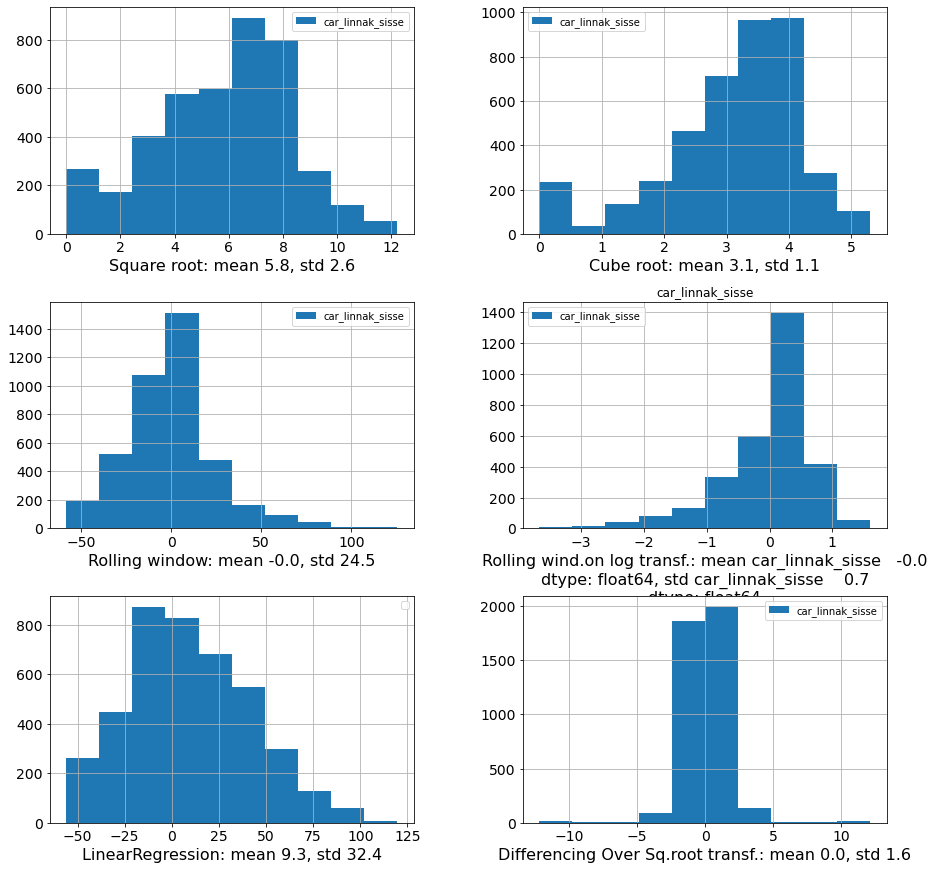

In [110]:
transform_All_hist(df_carvan_in, 'car_linnak_sisse', window=27)

In [111]:
van_sslin_log = log_transform(df_carvan_in, 'van_linnak_sisse')
van_sslin_powsq, van_sslin_powcu = power_transform(df_carvan_in, 'van_linnak_sisse')
van_sslin_rolwin = rolling_mean(df_carvan_in, 'van_linnak_sisse', window=27)
van_sslin_powrolw =  power_rolmean(df_carvan_in, 'van_linnak_sisse', window=27)
van_sslin_linr = linr_detrend(df_carvan_in, 'van_linnak_sisse')
van_sslin_pow_shift = power_transform_shift(df_carvan_in, 'van_linnak_sisse', periods=1)

No handles with labels found to put in legend.


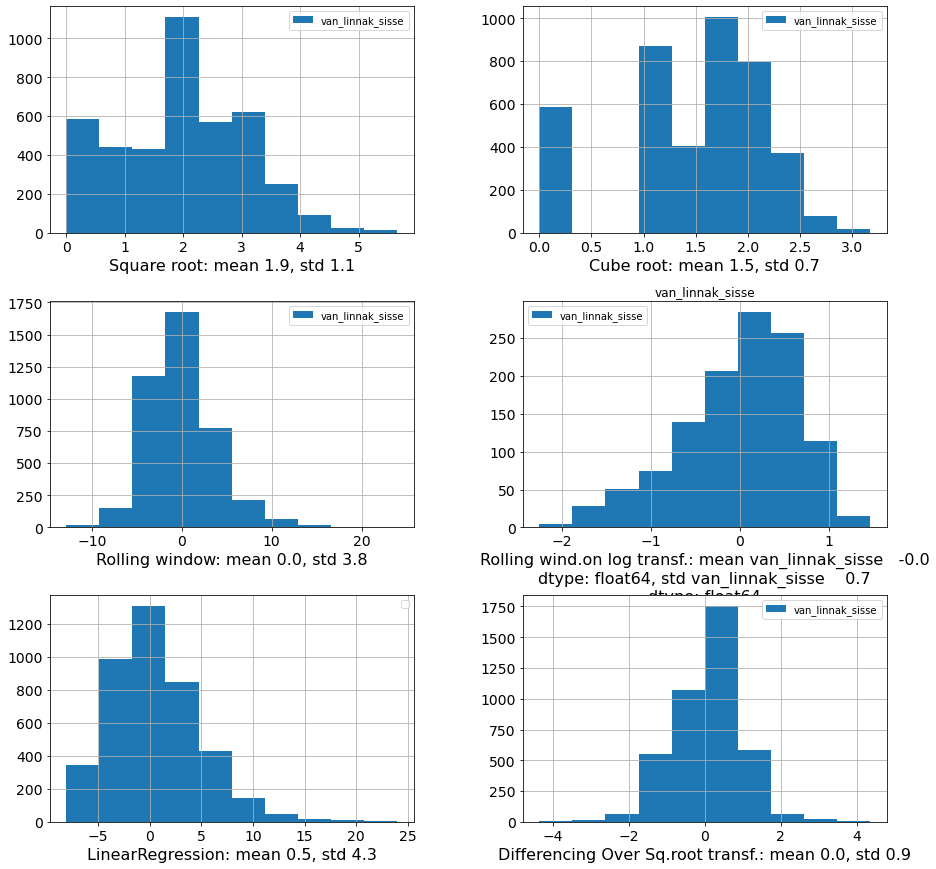

In [112]:
transform_All_hist(df_carvan_in, 'van_linnak_sisse', window=27)

In [113]:
car_sslout_log = log_transform(df_carvan_out, 'car_linnak_valja')
car_sslout_powsq, car_sslout_powcu = power_transform(df_carvan_out, 'car_linnak_valja')
car_sslout_rolwin = rolling_mean(df_carvan_out, 'car_linnak_valja', window=27)
car_sslout_powrolw =  power_rolmean(df_carvan_out, 'car_linnak_valja', window=27)
car_sslout_linr = linr_detrend(df_carvan_out, 'car_linnak_valja')
car_sslout_pow_shift = power_transform_shift(df_carvan_out, 'car_linnak_valja', periods=1)

No handles with labels found to put in legend.


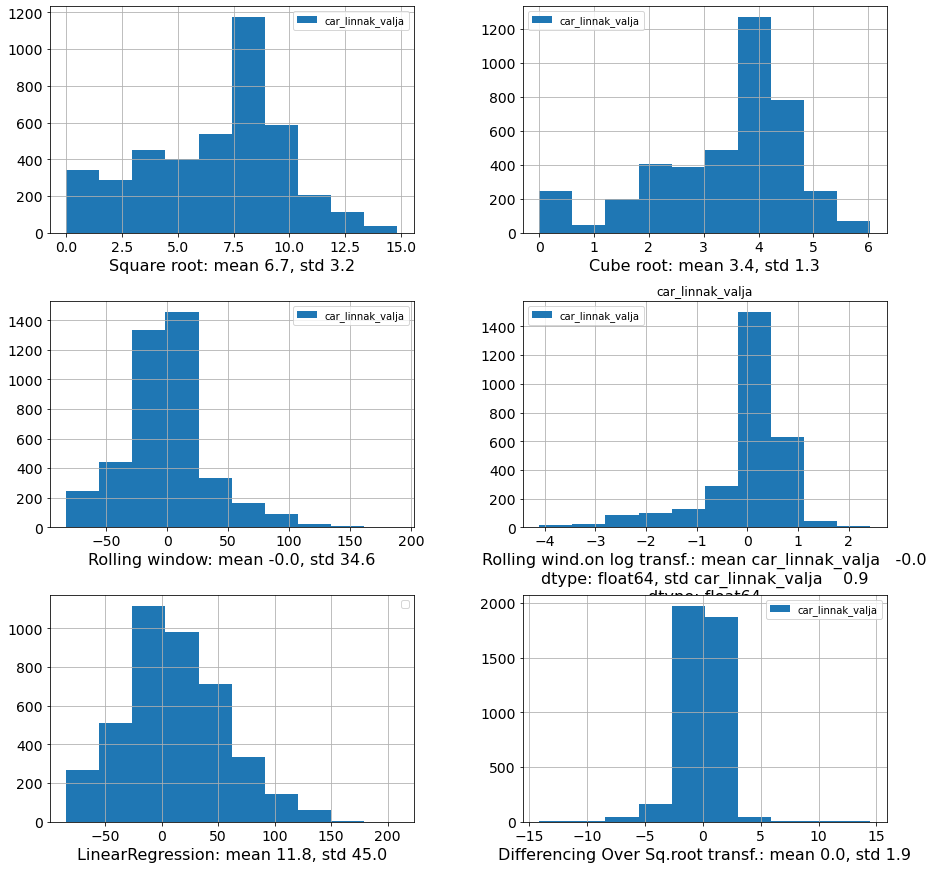

In [114]:
transform_All_hist(df_carvan_out, 'car_linnak_valja', window=27)

In [115]:
van_sslout_log = log_transform(df_carvan_out, 'van_linnak_valja')
van_sslout_powsq, van_sslout_powcu = power_transform(df_carvan_out, 'van_linnak_valja')
van_sslout_rolwin = rolling_mean(df_carvan_out, 'van_linnak_valja', window=27)
van_sslout_powrolw =  power_rolmean(df_carvan_out, 'van_linnak_valja', window=27)
van_sslout_linr = linr_detrend(df_carvan_out, 'van_linnak_valja')
van_sslout_pow_shift = power_transform_shift(df_carvan_out, 'van_linnak_valja', periods=1)

No handles with labels found to put in legend.


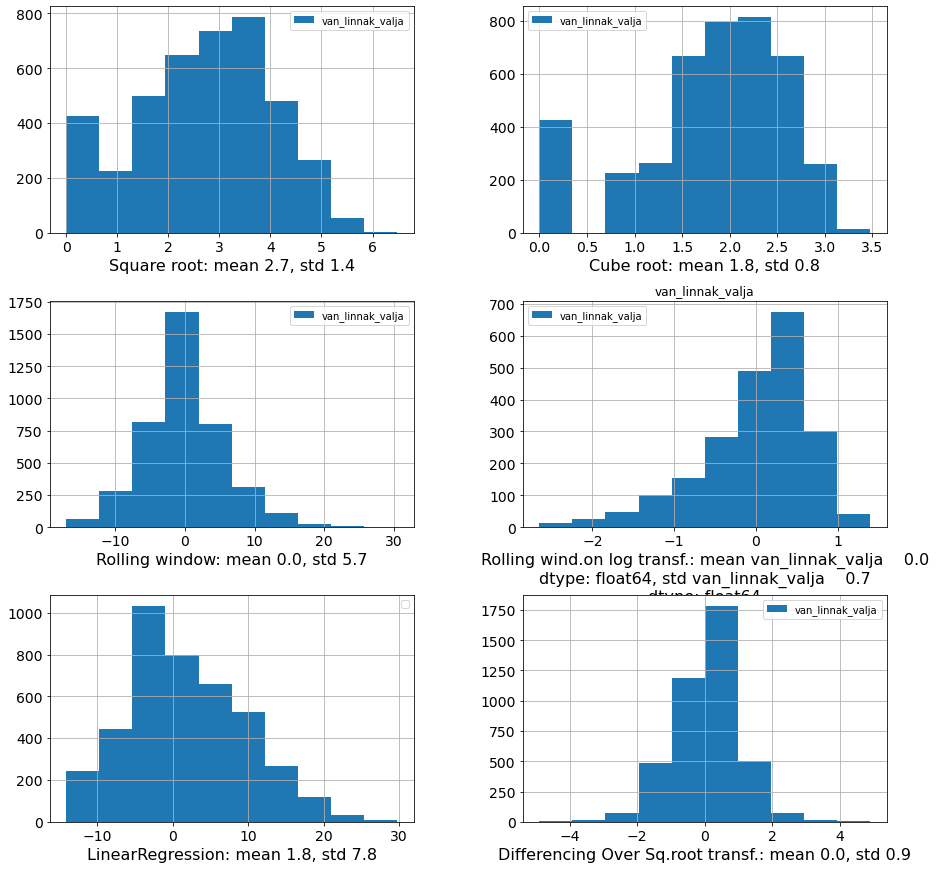

In [116]:
transform_All_hist(df_carvan_out, 'van_linnak_valja', window=27)

## TRANSFORMATION OF WEATHER DATA
## Exploring Trend and Seasonality of EMHI data
The target of the transformation of the original data is to modify it so that it would follow the Normal distribution as close as possible, i.e. bell-shaped.

In [117]:
print("ORIGINAL WEATHER FOR CAR/VAN LINNAK_SISSE/VÄLJA", data_emhi.shape)
print("ORIGINAL WEATHER FOR LIGHT_TRAFFIC", data_emhi_light.shape)

ORIGINAL WEATHER FOR CAR/VAN LINNAK_SISSE/VÄLJA (4131, 15)
ORIGINAL WEATHER FOR LIGHT_TRAFFIC (4131, 15)


### Wind_Speed [km/h]

Convert wind_speed from knots to km/h.

Teisendamine käib järgmise valemi järgi 1 sõlm = 1,852 km/h = 0,51444 m/s.

In [118]:
wind_speedkm = []

for i in data_emhi['tuulekiirus']:
    km_h = i * 1.852 
    wind_speedkm.append(km_h)

In [119]:
data_emhi.insert(loc=3, column='wind_speedkm', value=wind_speedkm)

In [120]:
wind_speed_log = log_transform(data_emhi, 'wind_speedkm')
wind_speed_powsq, wind_speed_powcu = power_transform(data_emhi, 'wind_speedkm')
wind_speed_rolwin = rolling_mean(data_emhi, 'wind_speedkm', window=27)
wind_speed_powrolw =  power_rolmean(data_emhi, 'wind_speedkm', window=27)
wind_speed_linr = linr_detrend(data_emhi, 'wind_speedkm')
wind_speed_pow_shift = power_transform_shift(data_emhi, 'wind_speedkm', periods=1)

No handles with labels found to put in legend.


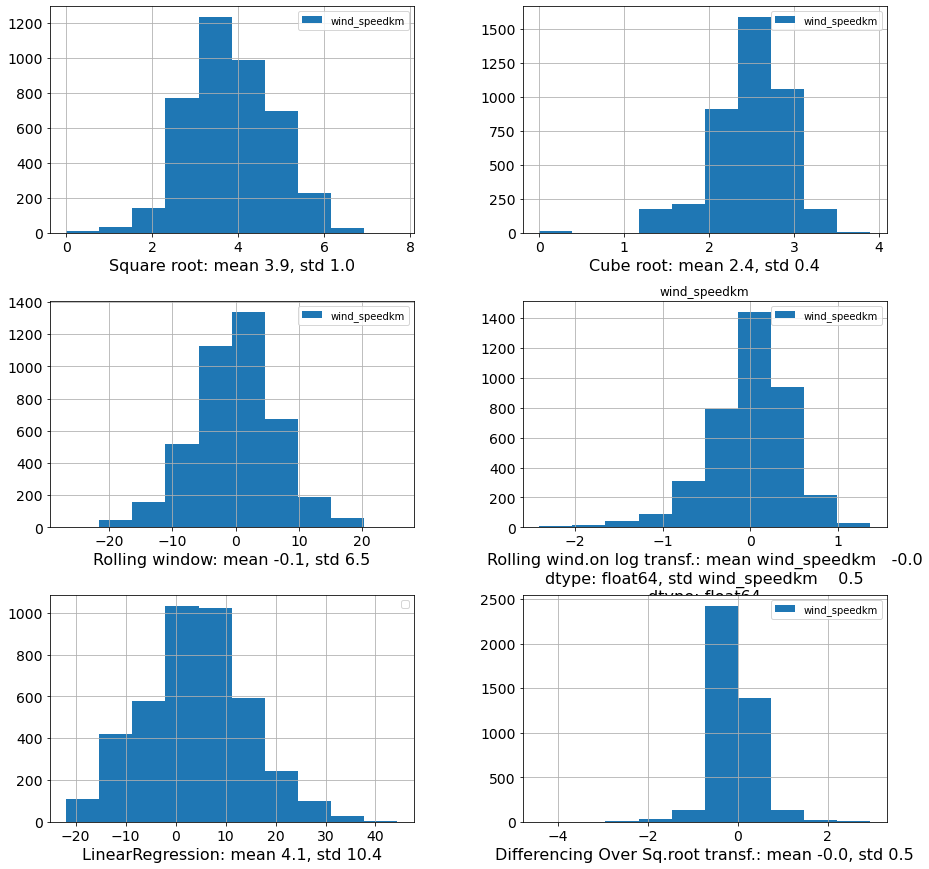

In [121]:
transform_All_hist(data_emhi, 'wind_speedkm', window=27)

### Temperature [deg Cels] (ORIGINAL)

### Visibility [m]

In [122]:
visib_log = log_transform(data_emhi, 'visibility_m')
visib_powsq, visib_powcu = power_transform(data_emhi, 'visibility_m')
visib_rolwin = rolling_mean(data_emhi, 'visibility_m', window=27)
visib_powrolw =  power_rolmean(data_emhi, 'visibility_m', window=27)
visib_linr = linr_detrend(data_emhi, 'visibility_m')
visib_pow_shift = power_transform_shift(data_emhi, 'visibility_m', periods=1)

No handles with labels found to put in legend.


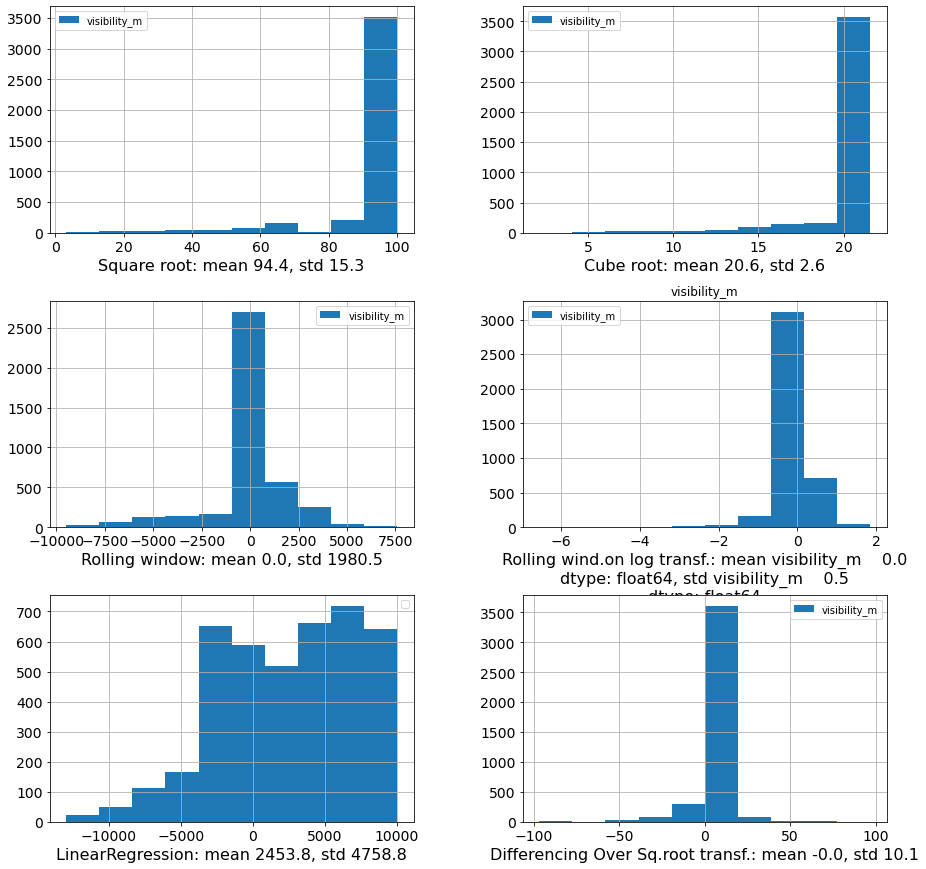

In [123]:
transform_All_hist(data_emhi, 'visibility_m', window=27)

### RH [%]

In [124]:
rh_log = log_transform(data_emhi, 'RH')
rh_powsq, rh_powcu = power_transform(data_emhi, 'RH')
rh_rolwin = rolling_mean(data_emhi, 'RH', window=27)
rh_powrolw =  power_rolmean(data_emhi, 'RH', window=27)
rh_linr = linr_detrend(data_emhi, 'RH')
rh_pow_shift = power_transform_shift(data_emhi, 'RH', periods=1)

No handles with labels found to put in legend.


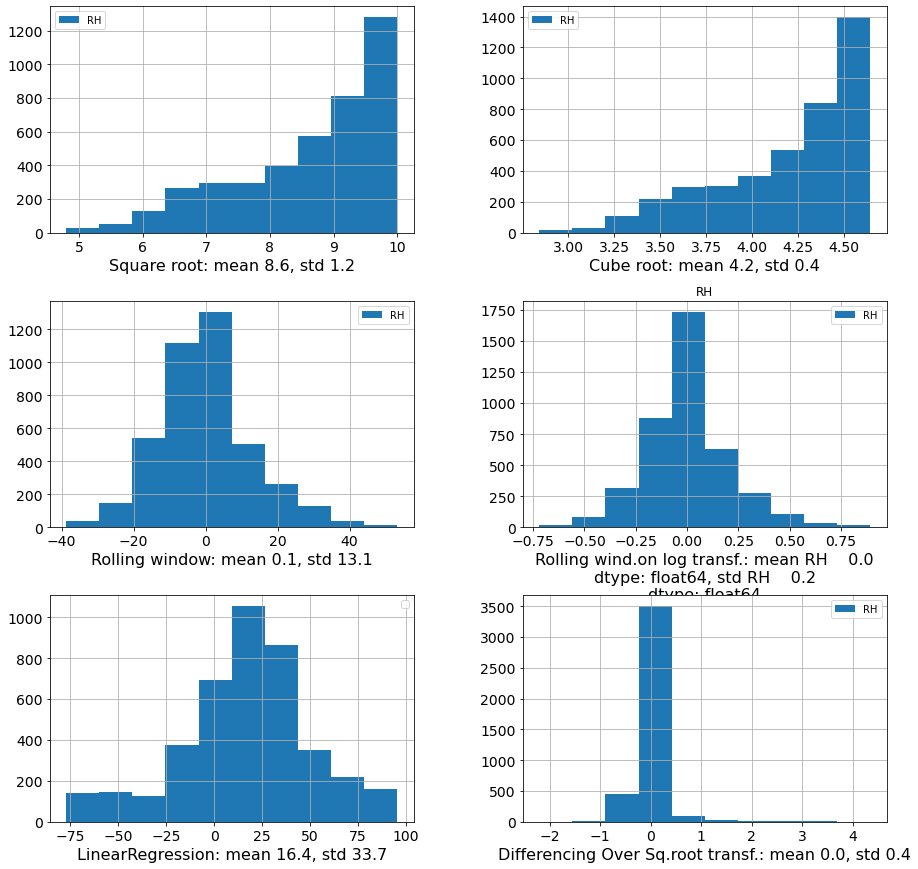

In [125]:
transform_All_hist(data_emhi, 'RH', window=27)

### Weather phenomena []  Stays Binary encoded

In [121]:
wphen_bin = data_emhi[['weather_phenCAT_0','weather_phenCAT_1' ,'weather_phenCAT_2']].copy()

In [122]:
wphen_bin.head(2)

,weather_phenCAT_0,weather_phenCAT_1,weather_phenCAT_2
kuupaev,,,
2021-04-06 05:50:00,0,0,1
2021-04-06 06:20:00,0,0,1


## WEATHER DATA FOR LIGHT_SISSE/VÄLJA

### Wind_speed [km/h]

In [123]:
wind_speedkm = []

for i in data_emhi_light['tuulekiirus']:
    km_h = i * 1.852 
    wind_speedkm.append(km_h)

In [124]:
data_emhi_light.insert(loc=3, column='wind_speedkm', value=wind_speedkm)

In [125]:
wind_speed_log_lgt = log_transform(data_emhi_light, 'wind_speedkm')
wind_speed_powsq_lgt, wind_speed_powcu_lgt = power_transform(data_emhi_light, 'wind_speedkm')
wind_speed_rolwin_lgt = rolling_mean(data_emhi_light, 'wind_speedkm', window=27)
wind_speed_powrolw_lgt =  power_rolmean(data_emhi_light, 'wind_speedkm', window=27)
wind_speed_linr_lgt = linr_detrend(data_emhi_light, 'wind_speedkm')
wind_speed_pow_shift_lgt = power_transform_shift(data_emhi_light, 'wind_speedkm', periods=1)

No handles with labels found to put in legend.


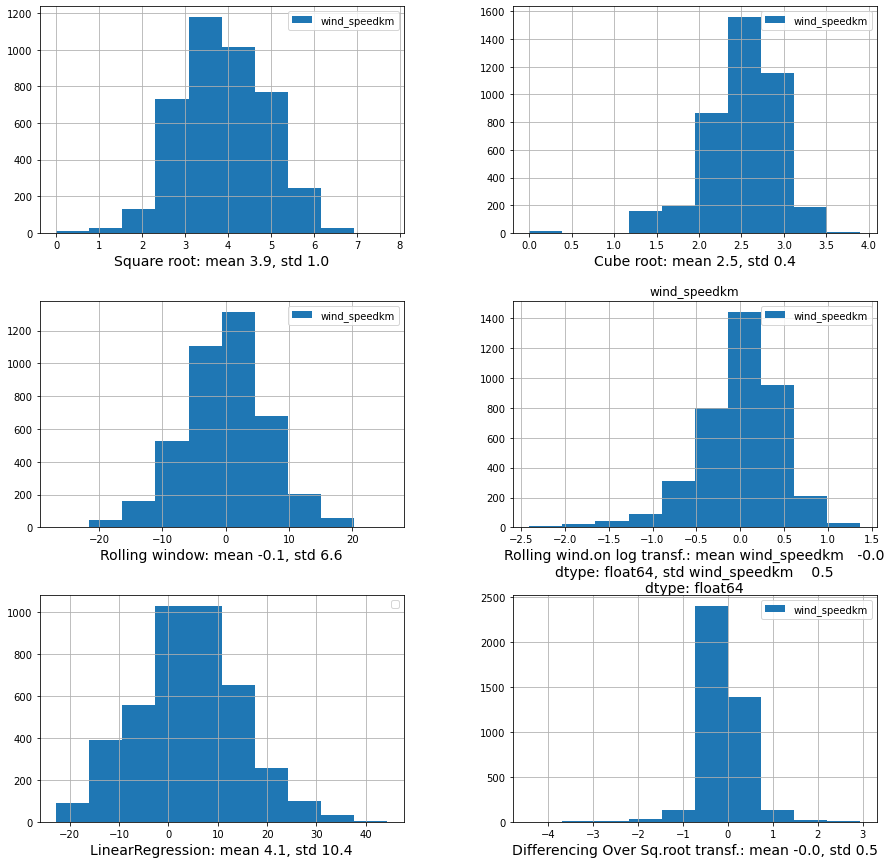

In [139]:
transform_All_hist(data_emhi_light, 'wind_speedkm', window=27)

### Visibility [m]

In [126]:
visib_log_lgt = log_transform(data_emhi_light, 'visibility_m')
visib_powsq_lgt, visib_powcu_lgt = power_transform(data_emhi_light, 'visibility_m')
visib_rolwin_lgt = rolling_mean(data_emhi_light, 'visibility_m', window=27)
visib_powrolw_lgt =  power_rolmean(data_emhi_light, 'visibility_m', window=27)
visib_linr_lgt = linr_detrend(data_emhi_light, 'visibility_m')
visib_pow_shift_lgt = power_transform_shift(data_emhi_light, 'visibility_m', periods=1)

### RH [%]

In [127]:
rh_log_lgt = log_transform(data_emhi_light, 'RH')
rh_powsq_lgt, rh_powcu_lgt = power_transform(data_emhi_light, 'RH')
rh_rolwin_lgt = rolling_mean(data_emhi_light, 'RH', window=27)
rh_powrolw_lgt =  power_rolmean(data_emhi_light, 'RH', window=27)
rh_linr_lgt = linr_detrend(data_emhi_light, 'RH')
rh_pow_shift_lgt = power_transform_shift(data_emhi_light, 'RH', periods=1)

### Weather phenomena [] Stays Binary encoded

In [128]:
wphen_bin_light = data_emhi_light[['weather_phenCAT_0','weather_phenCAT_1' ,'weather_phenCAT_2']].copy()


## CREATING DF WITH ALL VARIABLES, i.e. original traffic, weather + transformed weather, (traffic)
### to create 
## CORRELATION MATRIX

* Scatter plot between explanatory (weather properties) and forecasted variable will give a hint on possible relationship between those variables ??

* correlation matrix will be presented to reveal relationship and it’s strength between forecasted and explanatory variables.

* Features summary will be provided and decision made which variables and in which form will be retained to proceed with model development

### Original traffic and weather data

In [129]:
data_emhi.head(2)

,kellaaeg_utc,tuulesuund,tuulekiirus,wind_speedkm,nahtavus,visibility_m,ilmast_nahtused,weather_phenCAT,weather_phenLAB,pilvede_alapiir,temperatuur,RH,sademete_hulk,weather_phenCAT_0,weather_phenCAT_1,weather_phenCAT_2
kuupaev,,,,,,,,,,,,,,,,
2021-04-06 05:50:00,02:50:00,190,11,20.372,10,10000,0,NA,1,1./1400,-1.8,88,0.0,0,0,1
2021-04-06 06:20:00,03:20:00,190,12,22.224,10,10000,0,NA,1,2./1300,-1.5,87,0.0,0,0,1


In [130]:
car_sslin_orig = df_carvan_in['car_linnak_sisse']
car_sslout_orig = df_carvan_out['car_linnak_valja']

van_sslin_orig = df_carvan_in['van_linnak_sisse']
van_sslout_orig = df_carvan_out['van_linnak_valja']

light_ssl_orig = df_light['light_sisse_valja']

In [131]:
wind_speed_orig = data_emhi['wind_speedkm']
temp_orig = data_emhi['temperatuur']
visib_orig = data_emhi ['visibility_m']
rh_orig = data_emhi['RH']
#wphen_orig = data_emhi['weather_phenLAB']

In [132]:
wind_speed_orig_lgt = data_emhi_light['wind_speedkm']
temp_orig_lgt = data_emhi_light['temperatuur']
visib_orig_lgt = data_emhi_light['visibility_m']
rh_orig_lgt = data_emhi_light['RH']
#wphen_orig_lgt = data_emhi_light['weather_phenLAB']

In [133]:
print(wind_speed_orig.shape)
print(temp_orig.shape)
print(visib_orig.shape)
print(rh_orig.shape)
#print(wphen_orig.shape)

(4131,)
(4131,)
(4131,)
(4131,)


In [134]:
print(wind_speed_orig_lgt.shape)
print(temp_orig_lgt.shape)
print(visib_orig_lgt.shape)
print(rh_orig_lgt.shape)
#print(wphen_orig_lgt.shape)

(4131,)
(4131,)
(4131,)
(4131,)


## CAR/VAN_LINNAK_SISSE, CAR/VAN_LINNAK_VÄLJA

In [135]:
data_cor_traff = pd.concat([    
    car_sslin_orig, car_sslin_lag27, car_sslin_lag54, car_sslin_lag81,
    car_sslin_powsq, car_sslin_powcu, car_sslin_rolwin, car_sslin_linr, car_sslin_pow_shift,
    
    car_sslout_orig , car_sslout_lag27, car_sslout_lag54, car_sslout_lag81,
    car_sslout_powsq, car_sslout_powcu, car_sslout_rolwin, car_sslout_linr, car_sslout_pow_shift,
    
    van_sslin_orig, van_sslin_lag27, van_sslin_lag54, van_sslin_lag81,
    van_sslin_powsq, van_sslin_powcu, van_sslin_rolwin, van_sslin_linr, van_sslin_pow_shift,
    
    
    van_sslout_orig, van_sslout_lag27, van_sslout_lag54, van_sslout_lag81,
    van_sslout_powsq, van_sslout_powcu, van_sslout_rolwin, van_sslout_linr, van_sslout_pow_shift    
], axis=1)

In [136]:
data_cor_weath_traff = pd.concat([ 
    wind_speed_orig,temp_orig,visib_orig,rh_orig,
    
    wind_speed_powsq, wind_speed_powcu,wind_speed_rolwin, wind_speed_linr,wind_speed_pow_shift,
    
    visib_powsq, visib_powcu,visib_rolwin,visib_linr,visib_pow_shift,
    
    rh_powsq, rh_powcu,rh_rolwin,rh_linr,rh_pow_shift
], axis=1)

In [137]:
data_cor_traff.reset_index(drop=True, inplace=True)
data_cor_weath_traff.reset_index(drop=True, inplace=True)

In [138]:
data_cor_all_traff = pd.concat( [data_cor_traff, data_cor_weath_traff], axis=1) 

In [139]:
print(data_cor_all_traff.shape)
data_cor_all_traff.head(2)

(4131, 55)


,car_linnak_sisse,car_linnak_sisse,car_linnak_sisse,car_linnak_sisse,car_linnak_sisse,car_linnak_sisse,car_linnak_sisse,0,car_linnak_sisse,car_linnak_valja,...,visibility_m,visibility_m,visibility_m,1,visibility_m,RH,RH,RH,2,RH
0,1,5.0,3.0,0.0,1.0,1.0,NaN,1.000000,NaN,0,...,100.0,21.544347,NaN,10000.000000,NaN,9.380832,4.447960,NaN,88.000000,NaN
1,0,11.0,11.0,1.0,0.0,0.0,NaN,-0.014784,-1.0,0,...,100.0,21.544347,NaN,9996.761178,0.0,9.327379,4.431048,NaN,86.971331,-0.053452


In [140]:
data_cor_all_traff.columns = [
    
    'car_in_orig', 'car_in_lag27', 'car_in_lag54', 'car_in_lag81',
    'car_in_PowSq', 'car_in_PowCu', 'car_in_RolWin', 'car_in_LR', 'car_in_Pow_Shift',
    
    'car_out_orig', 'car_out_lag27', 'car_out_lag54', 'car_out_lag81',
    'car_out_PowSq', 'car_out_PowCu', 'car_out_RolWin', 'car_out_LR', 'car_out_Pow_Shift',
    
    'van_in_orig', 'van_in_lag27', 'van_in_lag54', 'van_in_lag81',
    'van_in_PowSq', 'van_in_PowCu', 'van_in_RolWin', 'van_in_LR', 'van_in_Pow_Shift', 
    
    'van_out_orig', 'van_out_lag27', 'van_out_lag54', 'van_out_lag81',
    'van_out_PowSq', 'van_out_PowCu', 'van_out_RolWin', 'van_out_LR', 'van_out_Pow_Shift', 
    
    
    'wind_speed_orig','temp_orig','visib_orig','rh_orig',
    'wind_speed_PowSq', 'wind_speed_PowCu','wind_speed_RolWin','wind_speed_LR','wind_speed_Pow_Shift',
    'visib_PowSq', 'visib_PowCu','visib_RolWin','visib_LR','visib_Pow_Shift',
    'rh_PowSq', 'rh_PowCu','rh_RolWin','rh_LR','rh_Pow_Shift'
]

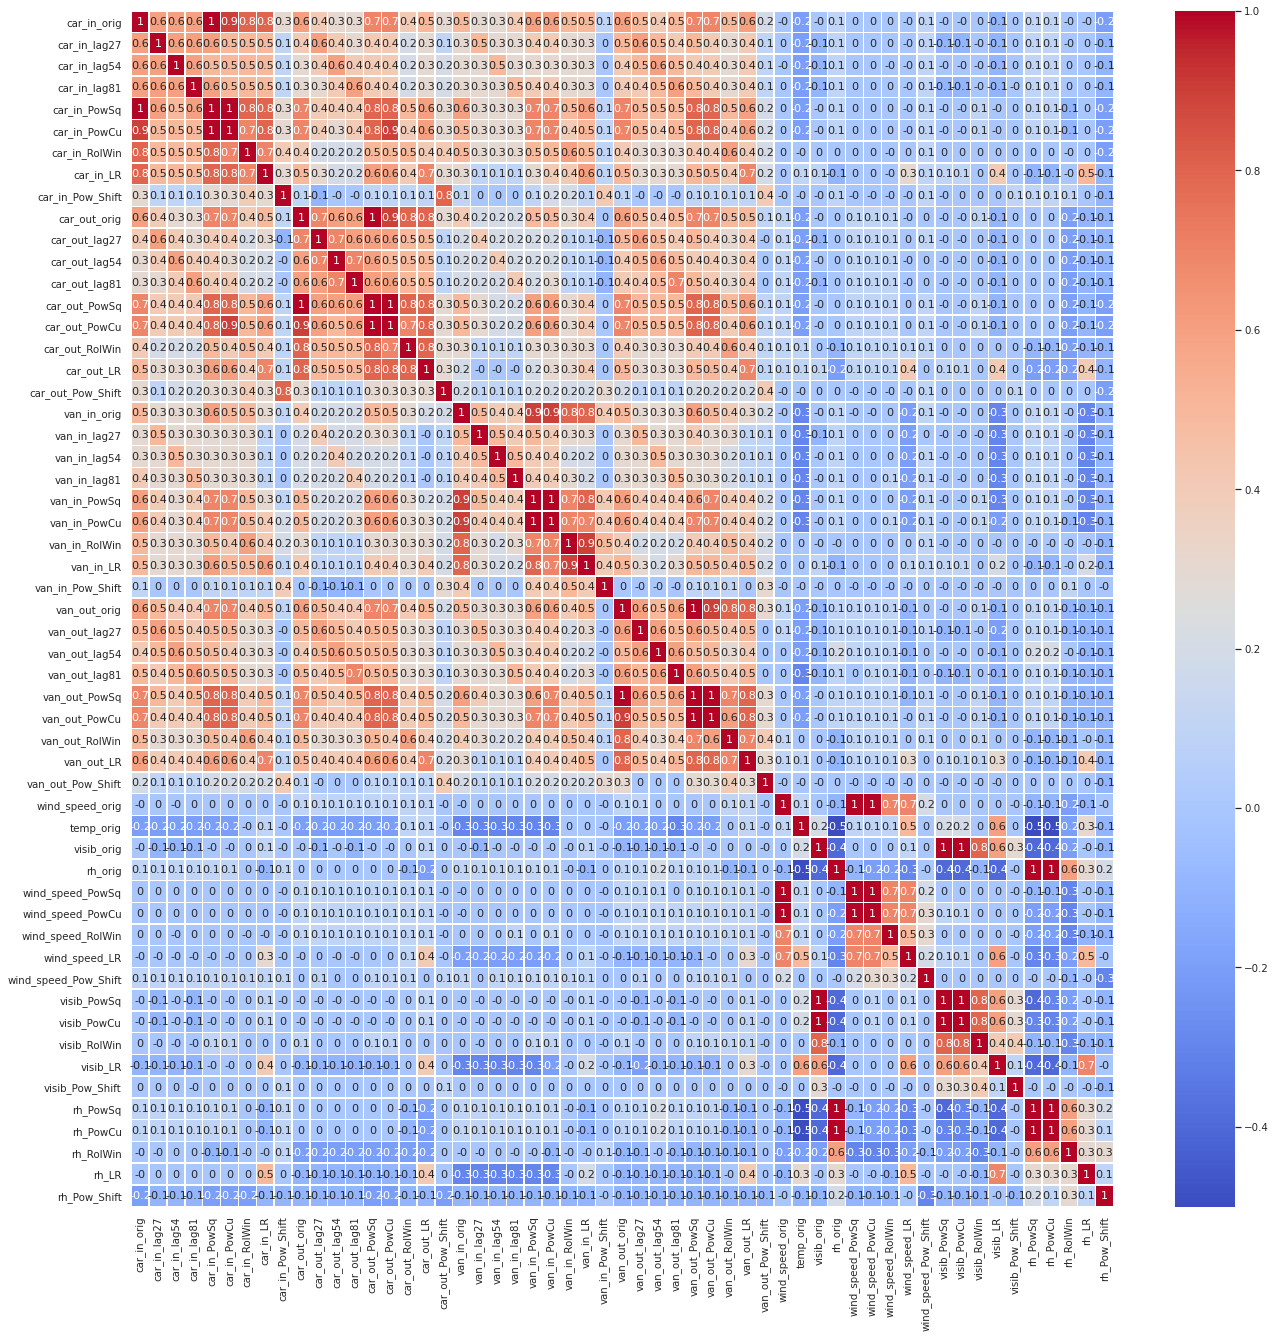

In [161]:
corr = data_cor_all_traff.corr()
plt.figure(figsize=(22,22))
sns.set(font_scale=0.93)
sns.heatmap(round(corr,1), cmap="coolwarm",annot=True, linewidths=.5)
plt.savefig(f"cor_all.pdf", format="pdf", bbox_inches="tight")
plt.show()

### CORRELATION MATRIC OF VARIABLES THAT ARE USED IN FURTHER MODELLING

In [142]:
data_cor_traff_used = pd.concat([    
    car_sslin_orig, car_sslin_lag27, car_sslin_lag54, car_sslin_lag81,
    
    car_sslout_orig , car_sslout_lag27, car_sslout_lag54, car_sslout_lag81,
    
    van_sslin_orig, van_sslin_lag27, van_sslin_lag54, van_sslin_lag81,   
    
    van_sslout_orig, van_sslout_lag27, van_sslout_lag54, van_sslout_lag81
], axis=1)

In [143]:
data_cor_weath_traff_used = pd.concat([ 
    wind_speed_orig, temp_orig, visib_orig, rh_orig,
    
    wind_speed_linr, visib_linr, rh_linr
], axis=1)

In [145]:
data_cor_traff_used.reset_index(drop=True, inplace=True)
data_cor_weath_traff_used.reset_index(drop=True, inplace=True)

In [146]:
data_cor_all_traff_used = pd.concat( [data_cor_traff_used, data_cor_weath_traff_used], axis=1) 

In [147]:
print(data_cor_all_traff_used.shape)
data_cor_all_traff_used.head(2)

(4131, 23)


,car_linnak_sisse,car_linnak_sisse,car_linnak_sisse,car_linnak_sisse,car_linnak_valja,car_linnak_valja,car_linnak_valja,car_linnak_valja,van_linnak_sisse,van_linnak_sisse,...,van_linnak_valja,van_linnak_valja,van_linnak_valja,wind_speedkm,temperatuur,visibility_m,RH,0,1,2
0,1,5.0,3.0,0.0,0,1.0,5.0,0.0,0.0,1.0,...,3.0,1.0,0.0,20.372,-1.8,10000,88,20.372000,10000.000000,88.000000
1,0,11.0,11.0,1.0,0,2.0,4.0,1.0,0.0,2.0,...,7.0,7.0,0.0,22.224,-1.5,10000,87,22.218214,9996.761178,86.971331


In [148]:
data_cor_all_traff_used.columns = [
    
    'car_in_orig', 'car_in_lag27', 'car_in_lag54', 'car_in_lag81',
  
    'car_out_orig', 'car_out_lag27', 'car_out_lag54', 'car_out_lag81',
    
    'van_in_orig', 'van_in_lag27', 'van_in_lag54', 'van_in_lag81',
    
    'van_out_orig', 'van_out_lag27', 'van_out_lag54', 'van_out_lag81',
    
    'wind_speed_orig','temp_orig','visib_orig','rh_orig',
    'wind_speed_LR', 'visib_LR','rh_LR'
]

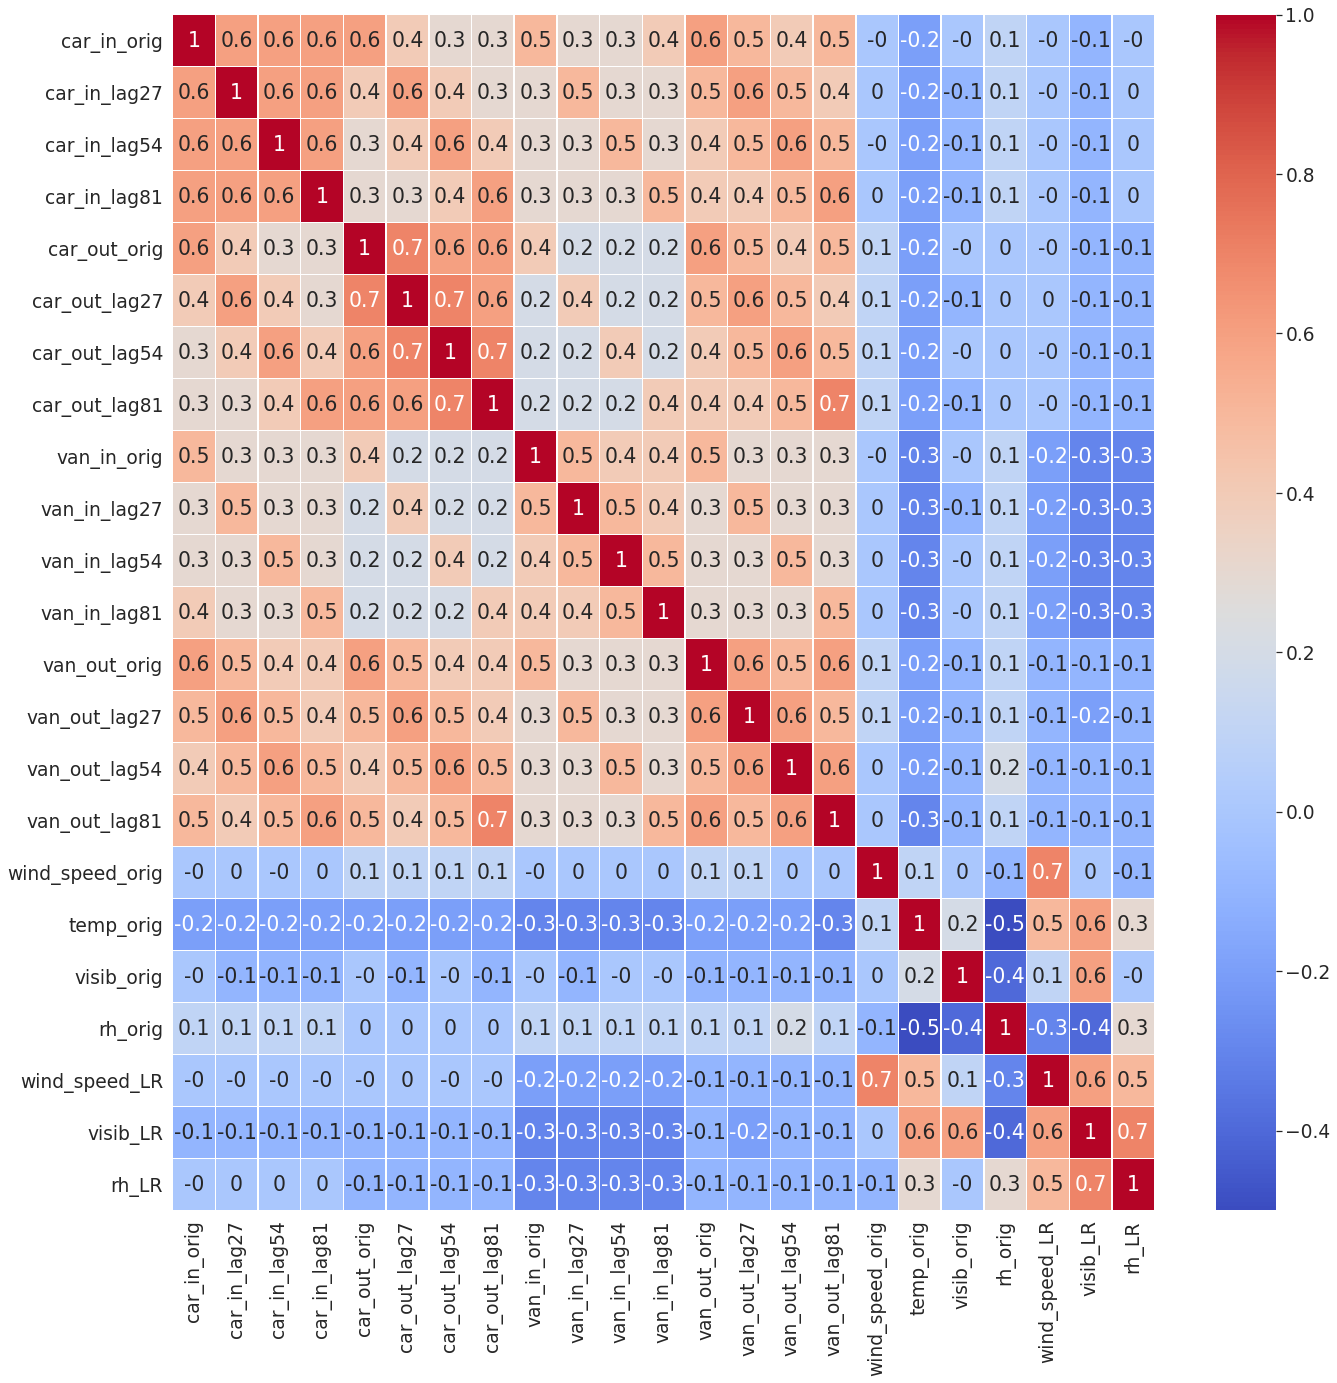

In [160]:
corr = data_cor_all_traff_used.corr()
plt.figure(figsize=(22,22))
sns.set(font_scale= 1.7)
sns.heatmap(round(corr,1), cmap="coolwarm",annot=True, linewidths=.5)
plt.savefig(f"cor_all_used.pdf", format="pdf", bbox_inches="tight")
plt.show()

## LIGHT_SISSE/VÄLJA (TRAFFIC DATA IS NOT TRANSFORMED)

In [153]:
data_cor_light = pd.concat([
    light_ssl_orig, light_ssl_lag27, light_ssl_lag54, light_ssl_lag81
], axis=1)

In [154]:
data_cor_weath_light = pd.concat([ 
    
    wind_speed_orig_lgt, temp_orig_lgt, visib_orig_lgt, rh_orig_lgt,
    wind_speed_powsq_lgt, wind_speed_powcu_lgt, wind_speed_rolwin_lgt, wind_speed_linr_lgt, wind_speed_pow_shift_lgt,
    
    visib_powsq_lgt, visib_powcu_lgt, visib_rolwin_lgt, visib_linr_lgt, 
    visib_pow_shift_lgt,
    rh_powsq_lgt, rh_powcu_lgt, rh_rolwin_lgt, rh_linr_lgt, rh_pow_shift_lgt,
], axis=1)

In [155]:
data_cor_light.reset_index(drop=True, inplace=True)
data_cor_weath_light.reset_index(drop=True, inplace=True)

In [156]:
data_cor_all_light = pd.concat( [data_cor_light, data_cor_weath_light], axis=1) 

In [157]:
print(data_cor_all_light.shape)
data_cor_all_light.head(2)

(4131, 23)


,light_sisse_valja,light_sisse_valja,light_sisse_valja,light_sisse_valja,wind_speedkm,temperatuur,visibility_m,RH,wind_speedkm,wind_speedkm,...,visibility_m,visibility_m,visibility_m,1,visibility_m,RH,RH,RH,2,RH
0,0,0.0,0.0,0.0,20.372,-1.8,10000,88,4.513535,2.731144,...,100.0,21.544347,NaN,10000.000000,NaN,9.380832,4.447960,NaN,88.000000,NaN
1,0,0.0,0.0,0.0,22.224,-1.5,10000,87,4.714234,2.811517,...,100.0,21.544347,NaN,9996.763277,0.0,9.327379,4.431048,NaN,86.970686,-0.053452


In [158]:
data_cor_all_light.columns = [
     'light_orig', 'light_lag27', 'light_lag54', 'light_lag81',
   
    'wind_speed_orig_lgt', 'temp_orig_lgt', 'visib_orig_llgt', 'rh_orig_lgt',
    
    'wind_speed_PowSq_lgt', 'wind_speed_PowCu_lgt', 'wind_speed_RolWin_lgt', 'wind_speed_LR_lgt',
    'wind_speed_PowShift_lgt',
    
    'visib_PowSq_lgt', 'visib_PowCu_lgt', 'visib_RolWin_lgt', 'visib_LR_lgt','visib_PowShift_lgt',
    
    'rh_PowSq_lgt', 'rh_PowCu_lgt', 'rh_RolWin_lgt', 'rh_LR_lgt', 'rh_PowShift_lgt'
]

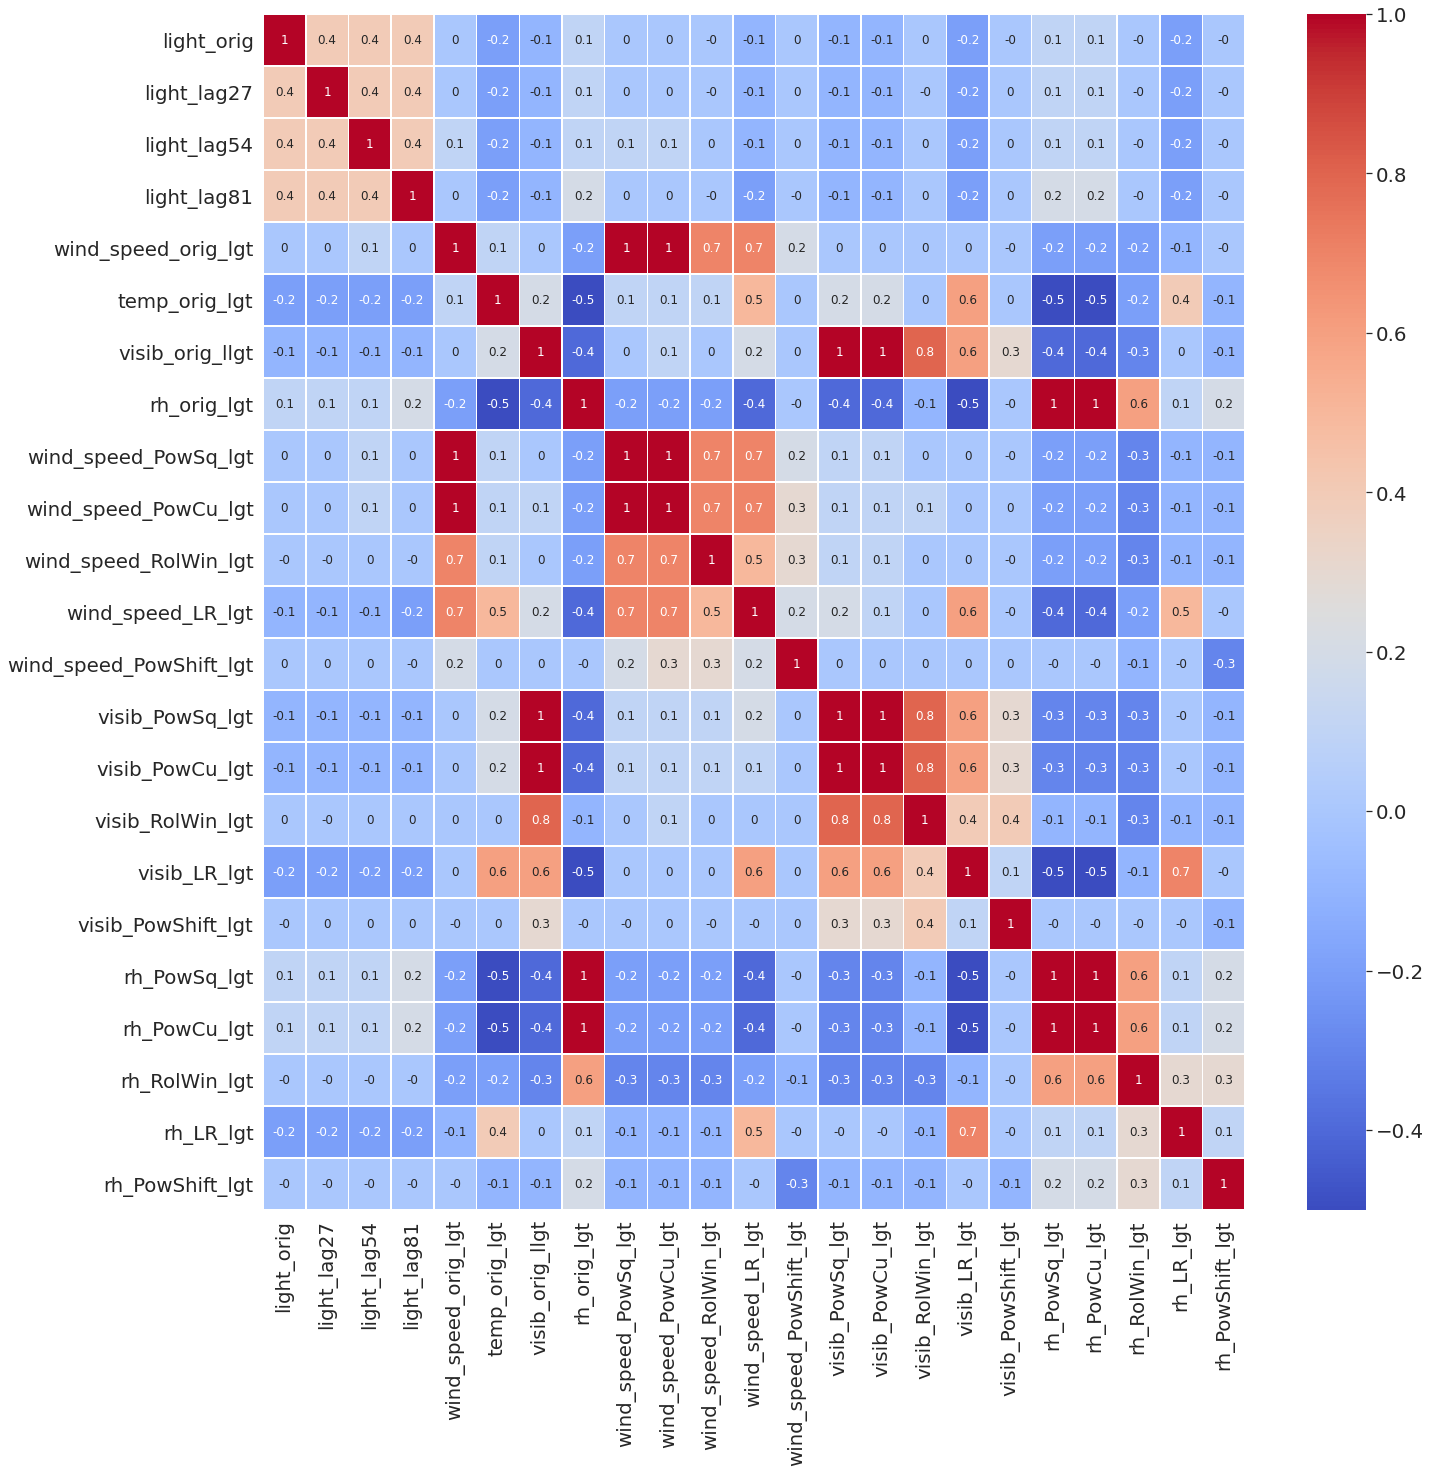

In [159]:
corr_light = data_cor_all_light.corr()
plt.figure(figsize=(22,22))
sns.set(font_scale=1.8)
sns.heatmap(round(corr_light,1), cmap="coolwarm",annot=True, linewidths=.5,annot_kws={"size":12})
plt.show()